In [1]:
import pickle
import h5py
from astropy.io import fits
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
simpars = ['\Omega_m','\sigma_8','\ log A_{SN1}','\log A_{AGN1} ','\log A_{SN2}','\log A_{AGN2}']
lims = [[0.1,0.5],[0.6,1.0],np.log([0.25,4.0]),np.log([0.25,4.0]),np.log([0.5,2.0]),np.log([0.5,2.0])]
SMALL_SIZE = 9
MEDIUM_SIZE = 9
BIGGER_SIZE = 9

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

# import matplotlib.font_manager
# matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
# sorted([f.name for f in matplotlib.font_manager.fontManager.ttflist])
plt.rc('font', family='Times New Roman')

plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'

## Splitting galaxies into two catagories:
Star forming/spiral and quiescent/elliptical.
This notebook explores properties about these two classes and how these properties change with varying simulation parameters.

The bottom code makes split samples of star forming and quiescent inputs for pipeline.

In [3]:
xyz = [[1,2], [2,0], [0,1]]
mean_SFR_unfilt = np.array([])
mean_SFR = np.array([])
mean_SSFR = np.array([])
mean_e = np.array([])
std_e = np.array([])
mean_g_r = np.array([])
mean_mass = np.array([])
mean_halfrad = np.array([])

mean_SFR_ell = np.array([])
mean_SSFR_ell = np.array([])
mean_e_ell = np.array([])
std_e_ell = np.array([])
mean_g_r_ell = np.array([])
mean_mass_ell = np.array([])
mean_halfrad_ell = np.array([])

mean_SFR_spi = np.array([])
mean_SSFR_spi = np.array([])
mean_e_spi = np.array([])
std_e_spi = np.array([])
mean_g_r_spi = np.array([])
mean_mass_spi = np.array([])
mean_halfrad_spi = np.array([])

filt_g_r = np.array([])
all_g_r = np.array([])
all_SFR = np.array([])
all_M_R_12 = np.array([])
all_nstar = np.array([])

filt_SFR = np.array([])
filt_M_R_12 = np.array([])
filt_M = np.array([])
filt_nstar = np.array([])
filt_halfrad = np.array([])
split_fracs = np.array([])
count=0
for filenum in range(0,1000):
    CAT = f'/Volumes/CAMELSDrive/Illustris_SUBFIND/LH{filenum}_SUBFIND.hdf5'
    # open 
    f = h5py.File(CAT, 'r')

    pos_sh  = f['Subhalo/SubhaloPos'][:]/1e3     #positions of SUBFIND subhalos in Mpc/h
    SFR_sh = f['Subhalo/SubhaloSFR'][:]
    subh_M_R_12 = f['Subhalo/SubhaloMassInRadType'][:,4]*1e10
    mass_sh = f['Subhalo/SubhaloMassType'][:,4]*1e10
    nstar_sh = f['Subhalo/SubhaloLenType'][:,4]
    photo_sh = f['Subhalo/SubhaloStellarPhotometrics'][:]
    halfrad_sh = f['Subhalo/SubhaloHalfmassRad'][:]
    # close file
    f.close()

    fits_file_path = f'LH_ellipticities/CAMELS_data_LHx{filenum}.fits'

    with fits.open(fits_file_path) as hdul:
        data = hdul[1].data
    pos_sh = np.array([pos_sh[:,1],pos_sh[:,2],pos_sh[:,0]]).T
    # Now you can use the same variable names
    pos_g = np.array([data['x'], data['y'], data['z']]).T
    ias = np.array([data['ia_1'], data['ia_2']]).T
#     print(pos_sh.shape, pos_g.shape)
    # getting all ellipticities 
#     fits_file_path = f'LH_ellipticities/CAMELS_data_LHx{filenum}.fits'
#     with fits.open(fits_file_path) as hdul:
#         data = hdul[1].data
#     ias = np.append(ias, np.array([data['ia_1'], data['ia_2']]).T,axis=0)
#     fits_file_path = f'LH_ellipticities/CAMELS_data_LHy{filenum}.fits'
#     with fits.open(fits_file_path) as hdul:
#         data = hdul[1].data
#     ias = np.append(ias, np.array([data['ia_1'], data['ia_2']]).T,axis=0)

    indices = np.where((pos_sh[:, None] == pos_g).all(axis=2).any(axis=1))[0]
    consistent = pos_g.shape[0]==indices.shape[0]
#     print(pos_g[:2], pos_sh[:2])
#     print(filenum ," ",consistent)
    # filter out elliptical
    if consistent:
        count+=indices.shape[0]
        g_r = (photo_sh[:,4] - photo_sh[:,5])
        filt_g_r = np.append(filt_g_r, g_r[indices])
        all_g_r = np.append(all_g_r, g_r)
#         print(len(SFR_sh[indices]))
#         print(sum(SFR_sh[indices]>0.1))
        all_SFR = np.append(all_SFR,SFR_sh)
        filt_SFR = np.append(filt_SFR,SFR_sh[indices])
        all_M_R_12 = np.append(all_M_R_12, subh_M_R_12)
        filt_M_R_12 = np.append(filt_M_R_12, subh_M_R_12[indices])
        filt_M = np.append(filt_M, mass_sh[indices])
        filt_halfrad = np.append(filt_halfrad, halfrad_sh[indices])
#         all_nstar = np.append(all_nstar, nstar_sh)
#         filt_nstar = np.append(filt_nstar, nstar_sh[indices])
#         all_gas = np.append(all_gas, ngas_sh)
#         filt_gas = np.append(filt_gas, ngas_sh[indices])
        mean_SFR = np.append(mean_SFR, np.mean(SFR_sh[indices]))
        mean_SFR_unfilt = np.append(mean_SFR_unfilt, np.mean(SFR_sh[subh_M_R_12>1e10]))
#         mean_SSFR = np.append(mean_SSFR, np.mean(SFR_sh[indices]/subh_M_R_12[indices]))
        mean_SSFR = np.append(mean_SSFR, np.mean(SFR_sh[indices]/mass_sh[indices]))
#         mean_SSFR2 = np.append(mean_SSFR2, (mass_sh[indices]-subh_M_R_12[indices])/mass_sh[indices])
        e = np.sqrt(ias[:,0]**2+ias[:,0]**2)
        mean_e = np.append(mean_e, np.mean(e))
        std_e = np.append(std_e, np.std(e))
        mean_g_r = np.append(mean_g_r, np.mean((g_r[indices])))
        mean_mass = np.append(mean_mass, mass_sh[indices])
        mean_halfrad = np.append(mean_halfrad, np.mean(halfrad_sh[indices]))
        
        SFR_g = SFR_sh[indices] #  galaxy SFR and Mass
        mass_g = mass_sh[indices]

        split = 10**-10.5
        elliptical = (SFR_g/mass_g)<split
        spiral = (SFR_g/mass_g)>=split
        
        print(filenum,len(pos_g[spiral]),len(pos_g[elliptical]))
        # fraction of reds vs blues
        split_fracs = np.append(split_fracs, len(pos_g[elliptical])/(len(pos_g[spiral])+len(pos_g[elliptical])))
        
        extended_elliptical = np.repeat(elliptical,3)
        extended_spiral = np.repeat(spiral,3)
        

        mean_SFR_ell = np.append(mean_SFR_ell, np.mean((SFR_sh[indices])[elliptical]))
        mean_SSFR_ell = np.append(mean_SSFR_ell, np.mean((SFR_sh[indices]/mass_sh[indices])[elliptical]))
        mean_e_ell = np.append(mean_e_ell, np.mean(e[elliptical]))
        std_e_ell = np.append(std_e_ell, np.std(e[elliptical]))
        mean_g_r_ell = np.append(mean_g_r_ell, np.mean((g_r[indices])[elliptical]))
        mean_mass_ell = np.append(mean_mass_ell, (mass_sh[indices])[elliptical])
        mean_halfrad_ell = np.append(mean_halfrad_ell, np.mean((halfrad_sh[indices])[elliptical]))
        
        mean_SFR_spi = np.append(mean_SFR_spi, np.mean((SFR_sh[indices])[spiral]))
        mean_SSFR_spi = np.append(mean_SSFR_spi, np.mean((SFR_sh[indices]/mass_sh[indices])[spiral]))
        mean_e_spi = np.append(mean_e_spi, np.mean(e[spiral]))
        std_e_spi = np.append(std_e_spi, np.std(e[spiral]))
        mean_g_r_spi = np.append(mean_g_r_spi, np.mean((g_r[indices])[spiral]))
        mean_mass_spi = np.append(mean_mass_spi, (mass_sh[indices])[spiral])
        mean_halfrad_spi = np.append(mean_halfrad_spi, np.mean((halfrad_sh[indices])[spiral]))
        
    else:
        print('Not consistent')


0 285 124
1 215 133
2 351 819
3 307 42
4 283 75
5 325 158
6 257 260
7 415 282
8 428 1359
9 737 781
10 346 1186
11 101 283
12 231 390
13 529 769
14 289 87
15 481 191
16 271 126
17 127 11
18 210 32
19 499 284
20 627 510
21 626 1049
22 454 204
23 335 150
24 643 321
25 284 98
26 315 339
27 570 288
28 663 1127
29 499 222
30 236 116
31 87 328
32 502 1137
33 278 79
34 221 532
35 559 632
36 459 238
37 201 308
38 306 177
39 209 71
40 155 100
41 368 1032
42 345 154
43 118 23
44 311 75
45 234 88
46 373 335
47 637 400
48 487 810
49 467 362
50 624 639
51 187 31
52 167 111
53 579 324
54 676 250
55 653 287
56 389 94
57 200 55
58 214 116
59 388 1333
60 373 399
61 385 325
62 792 429
63 692 426
64 214 81
65 430 1066
66 481 1135
67 670 549
68 308 125
69 515 603
70 301 1092
71 309 444
72 556 497
73 476 336
74 347 171
75 492 295
76 576 447
77 446 231
78 347 146
79 470 923
80 200 82
81 578 503
82 255 74
83 463 259
84 884 358
85 508 324
86 374 140
87 352 94
88 638 413
89 253 131
90 376 188
91 208 162
92 536 

699 326 795
700 547 245
701 291 178
702 449 357
703 585 436
704 521 452
705 283 538
706 417 82
707 381 914
708 287 247
709 543 315
710 457 276
711 688 635
712 236 68
713 194 23
714 899 471
715 717 161
716 229 139
717 723 487
718 259 73
719 102 45
720 335 325
721 687 359
722 457 168
723 448 617
724 347 322
725 384 140
726 387 103
727 364 281
728 340 104
729 410 113
730 279 140
731 691 610
732 479 221
733 232 120
734 164 130
735 204 398
736 633 436
737 269 150
738 123 119
739 208 8
740 588 783
741 217 310
742 678 362
743 235 58
744 443 199
745 694 889
746 185 269
747 187 45
748 592 499
749 425 94
750 273 166
751 207 64
752 314 549
753 436 279
754 472 1297
755 254 225
756 264 71
757 602 653
758 818 522
759 399 137
760 551 238
761 279 79
762 320 131
763 317 80
764 342 84
765 182 414
766 427 249
767 339 88
768 391 292
769 762 446
770 428 216
771 792 759
772 435 1075
773 159 162
774 457 574
775 493 71
776 151 61
777 190 175
778 712 494
779 287 243
780 709 543
781 433 752
782 287 48
783 343 3

In [69]:
print(len(SFR_sh), len(SFR_sh[nstar_sh>10]), len(SFR_sh[subh_M_R_12>1e10]), len(SFR_sh[(subh_M_R_12>1e8)&(nstar_sh>10)]))
print(count)

20505 804 66 756
823787


In [4]:
# save properties of galaxies
data = np.column_stack((mean_SFR, mean_SFR_spi, mean_SFR_ell, mean_SSFR, 
                        mean_SSFR_spi, mean_SSFR_ell, mean_e, mean_e_spi, mean_e_ell, std_e, std_e_spi, std_e_ell, split_fracs))

# Save to a text file
np.savetxt(
    "../sim_galaxyProperties.txt", 
    data, 
    fmt="%.6e",  # Format: scientific notation with 6 decimal places
    header="mean_SFR mean_SFR_spi mean_SFR_ell mean_SSFR mean_SSFR_spi mean_SSFR_ell mean_e mean_e_spi mean_e_ell std_e std_e_spi std_e_ell split_fracs",  # Column names
    comments=""  # Removes the '#' at the beginning of the header
)


In [7]:
data = np.loadtxt("../sim_galaxyProperties.txt", skiprows=1)  # Skip the header row
print(data[18,12])
# data = np.vstack((data, data, data))
mean_SFR, mean_SFR_spi, mean_SFR_ell, mean_SSFR, \
mean_SSFR_spi, mean_SSFR_ell, mean_e, mean_e_spi, \
mean_e_ell, std_e, std_e_spi, std_e_ell, split_fracs = data.T
# mean_SFR, mean_SSFR, mean_e, std_e, split_frac = data.T
# print(data[1018,12])

0.1322314


In [28]:
label_table = np.loadtxt("../test-dependence-folder/CosmoAstroSeed_IllustrisTNG_L25n256_LH.txt", skiprows=1, usecols=range(1, 7))
for i in range(label_table.shape[1]):
    if i>1:
        label_table[:,i] = np.log(label_table[:,i])

label_table[:,1] = label_table[:,1]**2
print(mean_SFR.shape, label_table.shape)

(1000,) (1000, 6)


In [29]:
# SAVING PEARSON VALUES
pearsons_SSFR = -np.ones((3,6))
p_vals_SSFR = -np.ones((3,6))
pearsons_e = -np.ones((3,6))
p_vals_e = -np.ones((3,6))

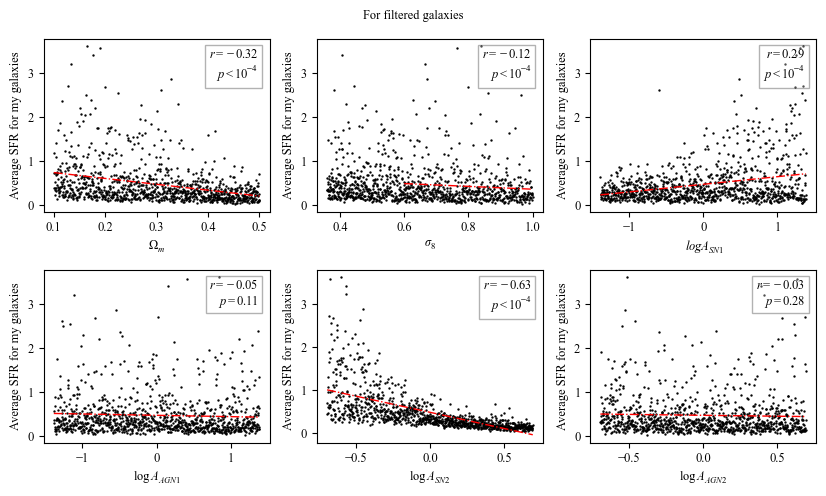

In [30]:
fig, axes = plt.subplots(2, 3, figsize=(25/3, 5))
axes = axes.flatten()
fig.suptitle('For filtered galaxies')
for i, param in enumerate(range(6)):
    ax = axes[i]
    
    slope, intercept = np.polyfit(label_table[:,param], mean_SFR, 1)
    x_vals = np.linspace(min(lims[param]), max(lims[param]), 10)
    y_vals = slope * x_vals + intercept
    ax.plot(x_vals, y_vals, lw=1, color='red', linestyle='-.', label=f"Linear Fit")
    
    pearson_coeff, p_value = pearsonr(label_table[:,param], mean_SFR)
    

    ax.scatter(label_table[:,param], mean_SFR, c='k', s=0.5)
    
    if p_value>1e-4:
        ax.text( 0.95, 0.95, 
        f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
        transform=ax.transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
    else:
        ax.text(0.95, 0.95, f"$r={pearson_coeff:.2f}$\n"+r'$p<10^{-4}$', transform=ax.transAxes, 
        fontsize=9, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="square", edgecolor='black',facecolor='white', alpha=0.3))

    ax.set_xlabel(f'${simpars[param]}$')
    ax.set_ylabel(f'Average SFR for my galaxies')
    
plt.tight_layout()
plt.savefig('/Users/danie/Library/CloudStorage/OneDrive-Personal/Physics UCL/Year 3/Astro Research Project 2023/avg SFR vs params.pdf', dpi=300)
plt.show()

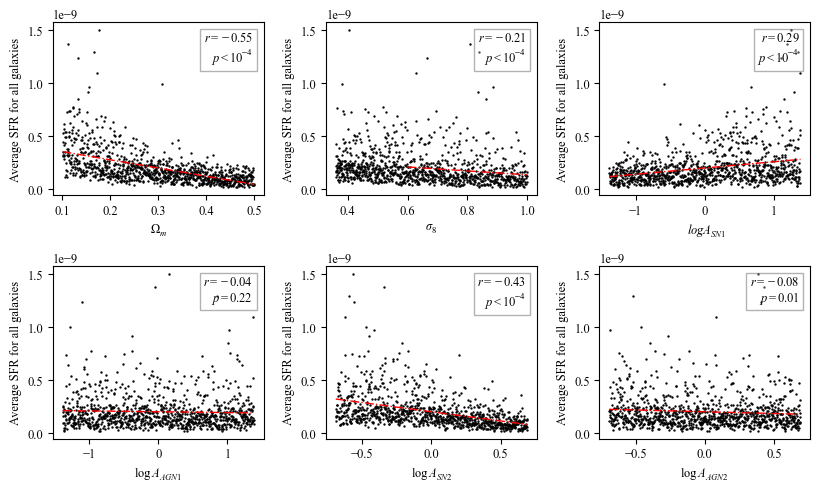

In [31]:
fig, axes = plt.subplots(2, 3, figsize=(25/3, 5))
axes = axes.flatten()
for i, param in enumerate(range(6)):
    ax = axes[i]
    
    slope, intercept = np.polyfit(label_table[:,param], mean_SSFR, 1)
    x_vals = np.linspace(min(lims[param]), max(lims[param]), 10)
    y_vals = slope * x_vals + intercept
    ax.plot(x_vals, y_vals, lw=1, color='red', linestyle='-.', label=f"Linear Fit")
    
    pearson_coeff, p_value = pearsonr(label_table[:,param], mean_SSFR)
    

    ax.scatter(label_table[:,param], mean_SSFR, c='k', s=0.5)
    
    if p_value>1e-4:
        ax.text( 0.95, 0.95, 
        f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
        transform=ax.transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
    else:
        ax.text(0.95, 0.95, f"$r={pearson_coeff:.2f}$\n"+r'$p<10^{-4}$', transform=ax.transAxes, 
        fontsize=9, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="square", edgecolor='black',facecolor='white', alpha=0.3))
    pearsons_SSFR[0,i] = pearson_coeff; p_vals_SSFR[0,i] = p_value
    ax.set_xlabel(f'${simpars[param]}$')
    ax.set_ylabel(f'Average SFR for all galaxies')
    
plt.tight_layout()

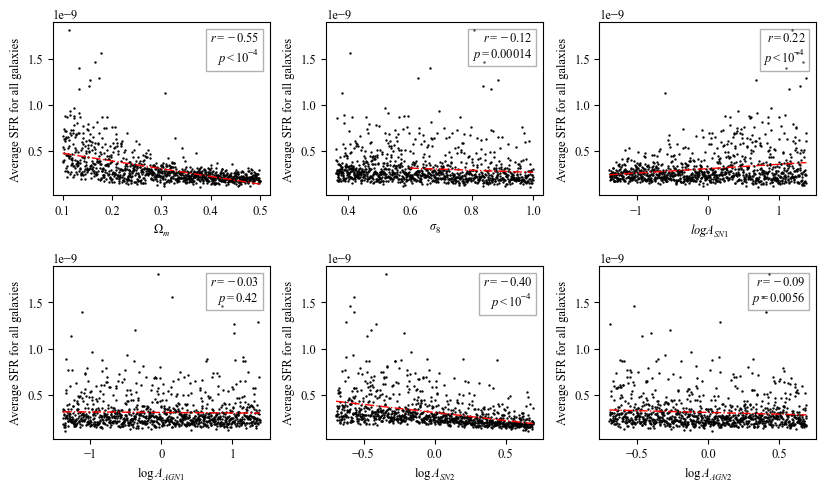

In [32]:
fig, axes = plt.subplots(2, 3, figsize=(25/3, 5))
axes = axes.flatten()
for i, param in enumerate(range(6)):
    ax = axes[i]
    
    slope, intercept = np.polyfit(label_table[:,param], mean_SSFR_spi, 1)
    x_vals = np.linspace(min(lims[param]), max(lims[param]), 10)
    y_vals = slope * x_vals + intercept
    ax.plot(x_vals, y_vals, lw=1, color='red', linestyle='-.', label=f"Linear Fit")
    
    pearson_coeff, p_value = pearsonr(label_table[:,param], mean_SSFR_spi)
    

    ax.scatter(label_table[:,param], mean_SSFR_spi, c='k', s=0.5)
    
    if p_value>1e-4:
        ax.text( 0.95, 0.95, 
        f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
        transform=ax.transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
    else:
        ax.text(0.95, 0.95, f"$r={pearson_coeff:.2f}$\n"+r'$p<10^{-4}$', transform=ax.transAxes, 
        fontsize=9, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="square", edgecolor='black',facecolor='white', alpha=0.3))
    pearsons_SSFR[1,i] = pearson_coeff; p_vals_SSFR[1,i] = p_value
    ax.set_xlabel(f'${simpars[param]}$')
    ax.set_ylabel(f'Average SFR for all galaxies')
    
plt.tight_layout()

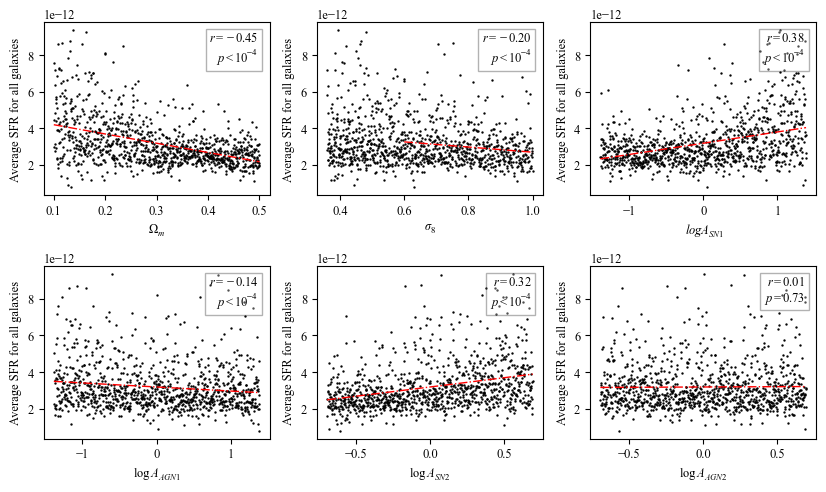

In [33]:
fig, axes = plt.subplots(2, 3, figsize=(25/3, 5))
axes = axes.flatten()
for i, param in enumerate(range(6)):
    ax = axes[i]
    
    slope, intercept = np.polyfit(label_table[:,param], mean_SSFR_ell, 1)
    x_vals = np.linspace(min(lims[param]), max(lims[param]), 10)
    y_vals = slope * x_vals + intercept
    ax.plot(x_vals, y_vals, lw=1, color='red', linestyle='-.', label=f"Linear Fit")
    
    pearson_coeff, p_value = pearsonr(label_table[:,param], mean_SSFR_ell)
    

    ax.scatter(label_table[:,param], mean_SSFR_ell, c='k', s=0.5)
    
    if p_value>1e-4:
        ax.text( 0.95, 0.95, 
        f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
        transform=ax.transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
    else:
        ax.text(0.95, 0.95, f"$r={pearson_coeff:.2f}$\n"+r'$p<10^{-4}$', transform=ax.transAxes, 
        fontsize=9, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="square", edgecolor='black',facecolor='white', alpha=0.3))
    pearsons_SSFR[2,i] = pearson_coeff; p_vals_SSFR[2,i] = p_value
    ax.set_xlabel(f'${simpars[param]}$')
    ax.set_ylabel(f'Average SFR for all galaxies')
    
plt.tight_layout()

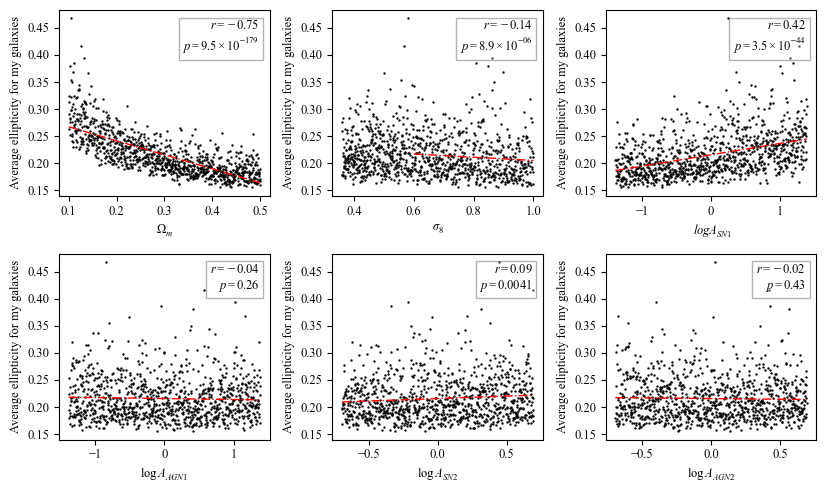

In [34]:
fig, axes = plt.subplots(2, 3, figsize=(25/3, 5))
axes = axes.flatten()
for i, param in enumerate(range(6)):
    ax = axes[i]
    
    slope, intercept = np.polyfit(label_table[:,param], mean_e, 1)
    x_vals = np.linspace(min(lims[param]), max(lims[param]), 10)
    y_vals = slope * x_vals + intercept
    ax.plot(x_vals, y_vals, lw=1, color='red', linestyle='-.', label=f"Linear Fit")
    
    pearson_coeff, p_value = pearsonr(label_table[:,param], mean_e)
    

    ax.scatter(label_table[:,param], mean_e, c='k', s=0.5)
    
    if p_value:
        ax.text( 0.95, 0.95, 
        f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
        transform=ax.transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
    else:
        ax.text(0.95, 0.95, f"$r={pearson_coeff:.2f}$\n"+r'$p<10^{-4}$', transform=ax.transAxes, 
        fontsize=9, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="square", edgecolor='black',facecolor='white', alpha=0.3))
    pearsons_e[0,i] = pearson_coeff; p_vals_e[0,i] = p_value
    ax.set_xlabel(f'${simpars[param]}$')
    ax.set_ylabel(f'Average ellipticity for my galaxies')
    
plt.tight_layout()

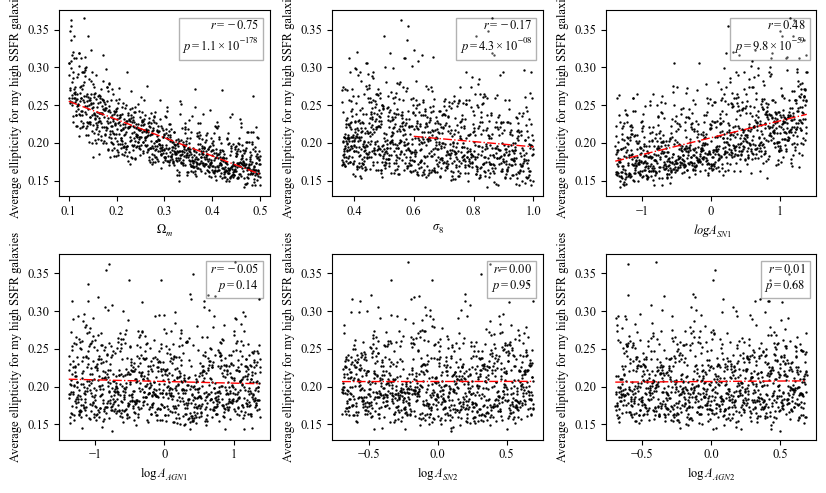

In [35]:
fig, axes = plt.subplots(2, 3, figsize=(25/3, 5))
axes = axes.flatten()
for i, param in enumerate(range(6)):
    ax = axes[i]
    
    slope, intercept = np.polyfit(label_table[:,param], mean_e_spi, 1)
    x_vals = np.linspace(min(lims[param]), max(lims[param]), 10)
    y_vals = slope * x_vals + intercept
    ax.plot(x_vals, y_vals, lw=1, color='red', linestyle='-.', label=f"Linear Fit")
    
    pearson_coeff, p_value = pearsonr(label_table[:,param], mean_e_spi)
    

    ax.scatter(label_table[:,param], mean_e_spi, c='k', s=0.5)
    
    if p_value:
        ax.text( 0.95, 0.95, 
        f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
        transform=ax.transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
    else:
        ax.text(0.95, 0.95, f"$r={pearson_coeff:.2f}$\n"+r'$p<10^{-4}$', transform=ax.transAxes, 
        fontsize=9, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="square", edgecolor='black',facecolor='white', alpha=0.3))
    pearsons_e[1,i] = pearson_coeff; p_vals_e[1,i] = p_value
    ax.set_xlabel(f'${simpars[param]}$')
    ax.set_ylabel(f'Average ellipticity for my high SSFR galaxies')
    
plt.tight_layout()

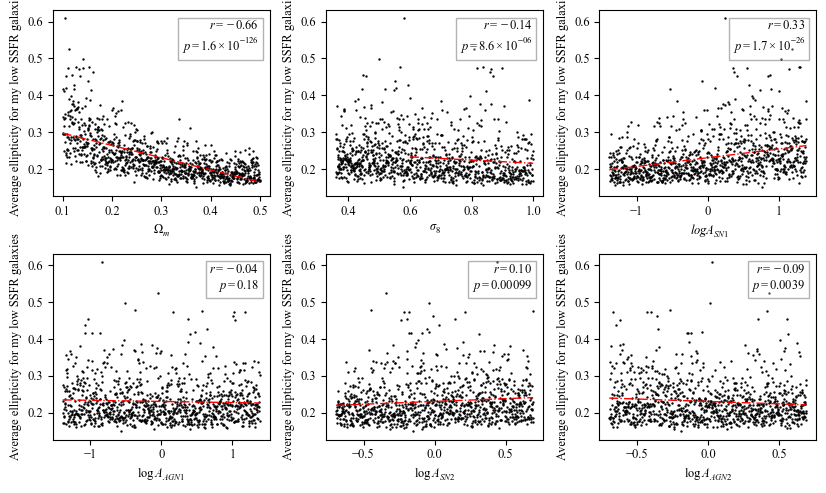

In [36]:
fig, axes = plt.subplots(2, 3, figsize=(25/3, 5))
axes = axes.flatten()
for i, param in enumerate(range(6)):
    ax = axes[i]
    
    slope, intercept = np.polyfit(label_table[:,param], mean_e_ell, 1)
    x_vals = np.linspace(min(lims[param]), max(lims[param]), 10)
    y_vals = slope * x_vals + intercept
    ax.plot(x_vals, y_vals, lw=1, color='red', linestyle='-.', label=f"Linear Fit")
    
    pearson_coeff, p_value = pearsonr(label_table[:,param], mean_e_ell)
    

    ax.scatter(label_table[:,param], mean_e_ell, c='k', s=0.5)
    
    if p_value:
        ax.text( 0.95, 0.95, 
        f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
        transform=ax.transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
    else:
        ax.text(0.95, 0.95, f"$r={pearson_coeff:.2f}$\n"+r'$p<10^{-4}$', transform=ax.transAxes, 
        fontsize=9, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="square", edgecolor='black',facecolor='white', alpha=0.3))
    pearsons_e[2,i] = pearson_coeff; p_vals_e[2,i] = p_value
    ax.set_xlabel(f'${simpars[param]}$')
    ax.set_ylabel(f'Average ellipticity for my low SSFR galaxies')
    
plt.tight_layout()

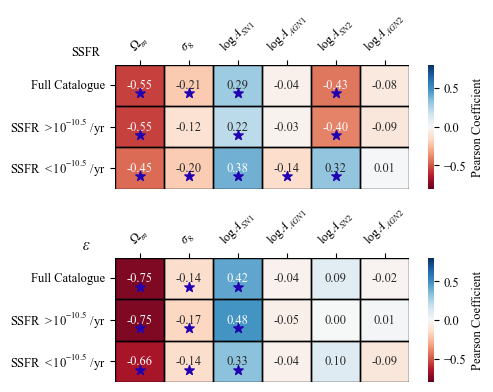

In [37]:
catalogues = ['Full Catalogue', 'SSFR $>10^{-10.5}$ /yr', 'SSFR $<10^{-10.5}$ /yr']
simpars_ = [r'$\Omega_m$', r'$\sigma_8$', r'$\log A_{SN1} $', r'$\log A_{AGN1}$', r'$\log A_{SN2}$', r'$\log A_{AGN2}$']
significance_mask = p_vals_SSFR < 1e-4
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(5, 4))
sns.heatmap(
    pearsons_SSFR, 
    annot=True,  
    fmt=".2f", 
    cmap="RdBu",  
    vmin=-.8, vmax=.8,  
    yticklabels=catalogues, 
    xticklabels=simpars_, ax=ax[0],
    cbar_kws={'label': 'Pearson Coefficient'}  
)
for y in range(pearsons_SSFR.shape[0]):  
    for x in range(pearsons_SSFR.shape[1]):  # Loop over columns
        if significance_mask[y, x]:  # Check if p-value is significant
            ax[0].scatter(x + 0.5, y + 0.7, color='xkcd:ultramarine', marker='*',s=50, zorder=10)
        ax[0].add_patch(plt.Rectangle((x, y), 1, 1, fill=False, edgecolor='xkcd:black', lw=1))  # Add border
ax[0].xaxis.set_ticks_position('top')
ax[0].xaxis.set_label_position('top')
ax[0].tick_params(axis='x', rotation=45)
ax[0].text(-0.1, 1.1, 'SSFR', fontsize=9, ha='center', va='center', transform=ax[0].transAxes)
significance_mask = p_vals_e < 1e-4
sns.heatmap(
    pearsons_e, 
    annot=True,  
    fmt=".2f", 
    cmap="RdBu",  
    vmin=-.8, vmax=.8,  
    yticklabels=catalogues, 
    xticklabels=simpars_, ax=ax[1],
    cbar_kws={'label': 'Pearson Coefficient'}  
)
for y in range(pearsons_e.shape[0]):  
    for x in range(pearsons_e.shape[1]):  # Loop over columns
        if significance_mask[y, x]:  # Check if p-value is significant
            ax[1].scatter(x + 0.5, y + 0.7, color='xkcd:ultramarine', marker='*',s=50, zorder=10)
        ax[1].add_patch(plt.Rectangle((x, y), 1, 1, fill=False, edgecolor='xkcd:black', lw=1))  # Add bord

    
ax[1].xaxis.set_ticks_position('top')
ax[1].xaxis.set_label_position('top')
ax[1].tick_params(axis='x', rotation=45)
ax[1].text(-0.1, 1.1, '$\epsilon$', fontsize=12, fontweight='bold', ha='center', va='center', transform=ax[1].transAxes)


plt.tight_layout()
plt.savefig(
    '/Users/danie/Library/CloudStorage/OneDrive-Personal/Physics UCL/Year 3/Astro Research Project 2023/SSFR e table.pdf',
    dpi=300, bbox_inches='tight')
plt.show()

In [39]:
min(label_table[:,1])

0.36024003999999993

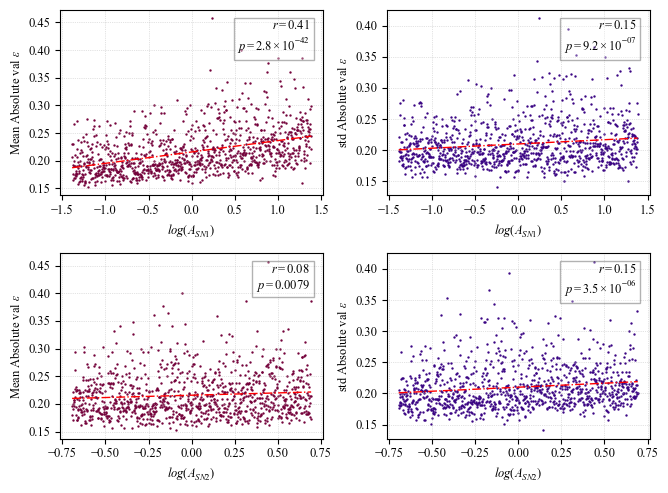

In [92]:
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(20/3,5))
axes = ax.flatten()
for axis in axes:
    axis.grid(which='both', linestyle='dotted', linewidth=0.5, alpha=0.7)
      
axes[0].scatter(label_table[:,2], mean_e, c='xkcd:merlot', s=0.5)
slope, intercept = np.polyfit(label_table[:,2], mean_e, 1)
x_vals = np.linspace(min(lims[2]), max(lims[2]), 10)
y_vals = slope * x_vals + intercept
axes[0].plot(x_vals, y_vals, lw=1, color='red', linestyle='-.', label=f"Linear Fit")

pearson_coeff, p_value = pearsonr(label_table[:,2], mean_e)
if p_value:
    axes[0].text( 0.95, 0.95, 
    f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
    transform=axes[0].transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
    bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
else:
    axes[0].text(0.95, 0.95, f"$r={pearson_coeff:.2f}$\n"+r'$p<10^{-4}$', transform=axes[0].transAxes, 
    fontsize=9, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="square", edgecolor='black',facecolor='white', alpha=0.3))
axes[0].set_xlabel(f'${simpars[2]}$')
axes[0].set_ylabel(r'Mean Absolute val $\epsilon$')
axes[1].scatter(label_table[:,2], std_e, c='xkcd:indigo', s=0.5)
slope, intercept = np.polyfit(label_table[:,2], std_e, 1)
x_vals = np.linspace(min(lims[2]), max(lims[2]), 10)
y_vals = slope * x_vals + intercept
axes[1].plot(x_vals, y_vals, lw=1, color='red', linestyle='-.', label=f"Linear Fit")

pearson_coeff, p_value = pearsonr(label_table[:,2], std_e)
if p_value:
    axes[1].text( 0.95, 0.95, 
    f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
    transform=axes[1].transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
    bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
else:
    axes[1].text(0.95, 0.95, f"$r={pearson_coeff:.2f}$\n"+r'$p<10^{-4}$', transform=axes[1].transAxes, 
    fontsize=9, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="square", edgecolor='black',facecolor='white', alpha=0.3))

axes[1].set_ylabel(r'std Absolute val $\epsilon$')
axes[1].set_xlabel(f'${simpars[2]}$')
axes[2].scatter(label_table[:,4], mean_e, c='xkcd:merlot', s=0.5)
slope, intercept = np.polyfit(label_table[:,4], mean_e, 1)
x_vals = np.linspace(min(lims[4]), max(lims[4]), 10)
y_vals = slope * x_vals + intercept
axes[2].plot(x_vals, y_vals, lw=1, color='red', linestyle='-.', label=f"Linear Fit")

pearson_coeff, p_value = pearsonr(label_table[:,4], mean_e)
if p_value:
    axes[2].text( 0.95, 0.95, 
    f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
    transform=axes[2].transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
    bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
else:
    axes[2].text(0.95, 0.95, f"$r={pearson_coeff:.2f}$\n"+r'$p<10^{-4}$', transform=axes[2].transAxes, 
    fontsize=9, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="square", edgecolor='black',facecolor='white', alpha=0.3))

axes[2].set_ylabel(r'Mean Absolute val $\epsilon$')
axes[2].set_xlabel(f'${simpars[4]}$')
axes[3].scatter(label_table[:,4], std_e, c='xkcd:indigo', s=0.5)
slope, intercept = np.polyfit(label_table[:,4], std_e, 1)
x_vals = np.linspace(min(lims[4]), max(lims[4]), 10)
y_vals = slope * x_vals + intercept
axes[3].plot(x_vals, y_vals, lw=1, color='red', linestyle='-.', label=f"Linear Fit")

pearson_coeff, p_value = pearsonr(label_table[:,4], std_e)
if p_value:
    axes[3].text( 0.95, 0.95, 
    f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
    transform=axes[3].transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
    bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
else:
    axes[3].text(0.95, 0.95, f"$r={pearson_coeff:.2f}$\n"+r'$p<10^{-4}$', transform=axes[3].transAxes, 
    fontsize=9, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="square", edgecolor='black',facecolor='white', alpha=0.3))

axes[3].set_ylabel(r'std Absolute val $\epsilon$')
axes[3].set_xlabel(f'${simpars[4]}$')
plt.tight_layout()
plt.savefig('/Users/danie/Library/CloudStorage/OneDrive-Personal/Physics UCL/Year 3/Astro Research Project 2023/ell vs params.pdf', dpi=300)
plt.show()

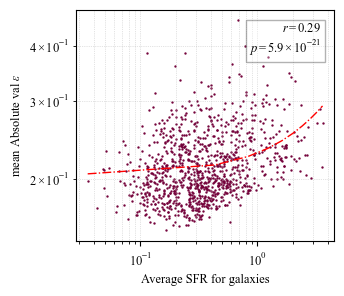

In [243]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10/3,3))
ax.grid(which='both', linestyle='dotted', linewidth=0.5, alpha=0.7)

ax.scatter(mean_SFR, mean_e, c='xkcd:merlot', s=0.5)
slope, intercept = np.polyfit(mean_SFR, mean_e, 1)
x_vals = np.linspace(min(mean_SFR), max(mean_SFR), 10)
y_vals = slope * x_vals + intercept
ax.plot(x_vals, y_vals, lw=1, color='red', linestyle='-.', label=f"Linear Fit")

pearson_coeff, p_value = pearsonr(mean_SFR, mean_e)
if p_value:
    ax.text( 0.95, 0.95, 
    f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
    transform=ax.transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
    bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
    
    
ax.set_ylabel(r'mean Absolute val $\epsilon$')
ax.set_xlabel(f'Average SFR for galaxies')
# ax.set_xscale('log')
# ax.set_yscale('log')

/var/folders/2k/4lvm79j14sg5_v8dqx8tly7h0000gn/T/ipykernel_31348/505772856.py:54: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


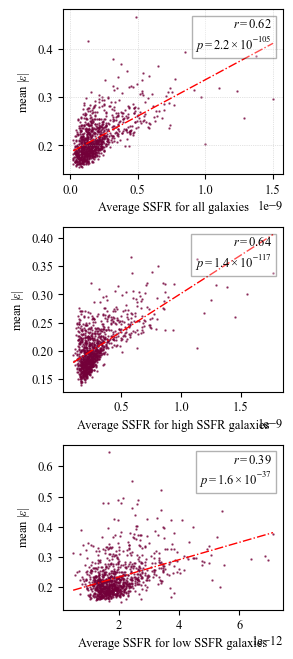

In [40]:
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(3,20/3))
ax[0].grid(which='both', linestyle='dotted', linewidth=0.5, alpha=0.7)

ax[0].scatter(mean_SSFR, mean_e, c='xkcd:merlot', s=0.5,alpha=0.7)
slope, intercept = np.polyfit(mean_SSFR, mean_e, 1)
x_vals = np.linspace(min(mean_SSFR), max(mean_SSFR), 100)
y_vals = slope * x_vals + intercept
ax[0].plot(x_vals, y_vals, lw=1, color='red', linestyle='-.', label=f"Linear Fit")

pearson_coeff, p_value = pearsonr(mean_SSFR, mean_e)
if p_value:
    ax[0].text( 0.95, 0.95, 
    f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
    transform=ax[0].transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
    bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
    
ax[0].set_ylabel(r'mean $|\epsilon|$')
ax[0].set_xlabel(f'Average SSFR for all galaxies')

ax[1].scatter(mean_SSFR_spi, mean_e_spi, c='xkcd:merlot', s=0.5,alpha=0.7)
slope, intercept = np.polyfit(mean_SSFR_spi, mean_e_spi, 1)
x_vals = np.linspace(min(mean_SSFR_spi), max(mean_SSFR_spi), 100)
y_vals = slope * x_vals + intercept
ax[1].plot(x_vals, y_vals, lw=1, color='red', linestyle='-.', label=f"Linear Fit")

pearson_coeff, p_value = pearsonr(mean_SSFR_spi, mean_e_spi)
if p_value:
    ax[1].text( 0.95, 0.95, 
    f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
    transform=ax[1].transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
    bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
    
ax[1].set_ylabel(r'mean $|\epsilon|$')
ax[1].set_xlabel(f'Average SSFR for high SSFR galaxies')

ax[2].scatter(mean_SSFR_ell, mean_e_ell, c='xkcd:merlot', s=0.5,alpha=0.7)
slope, intercept = np.polyfit(mean_SSFR_ell, mean_e_ell, 1)
x_vals = np.linspace(min(mean_SSFR_ell), max(mean_SSFR_ell), 100)
y_vals = slope * x_vals + intercept
ax[2].plot(x_vals, y_vals, lw=1, color='red', linestyle='-.', label=f"Linear Fit")

pearson_coeff, p_value = pearsonr(mean_SSFR_ell, mean_e_ell)
if p_value:
    ax[2].text( 0.95, 0.95, 
    f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
    transform=ax[2].transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
    bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
    
ax[2].set_ylabel(r'mean $|\epsilon|$')
ax[2].set_xlabel(f'Average SSFR for low SSFR galaxies')
plt.tight_layout( h_pad=-1, w_pad=None, rect=None)
# ax.set_xscale('log')
# ax.set_yscale('log')
plt.tight_layout()
plt.savefig(
    '/Users/danie/Library/CloudStorage/OneDrive-Personal/Physics UCL/Year 3/Astro Research Project 2023/mean SSFR vs mean e.pdf',
    dpi=300)

Text(0, 0.5, 'Average g-r for galaxies')

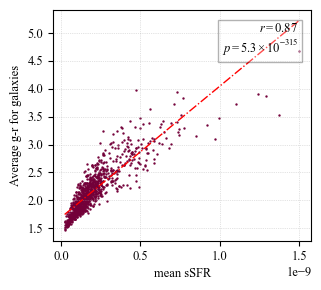

In [41]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10/3,3))
ax.grid(which='both', linestyle='dotted', linewidth=0.5, alpha=0.7)

ax.scatter(mean_SSFR, 1/mean_g_r, c='xkcd:merlot', s=0.5)
slope, intercept = np.polyfit(mean_SSFR, 1/mean_g_r, 1)
x_vals = np.linspace(min(mean_SSFR), max(mean_SSFR), 10)
y_vals = slope * x_vals + intercept
ax.plot(x_vals, y_vals, lw=1, color='red', linestyle='-.', label=f"Linear Fit")

pearson_coeff, p_value = pearsonr(mean_SSFR, 1/mean_g_r)
if p_value:
    ax.text( 0.95, 0.95, 
    f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
    transform=ax.transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
    bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
    
    
ax.set_xlabel(r'mean sSFR')
ax.set_ylabel(f'Average g-r for galaxies')


#### Rescaling ellipticities to account for SFR

Text(0.5, 0, 'Average SFR for galaxies')

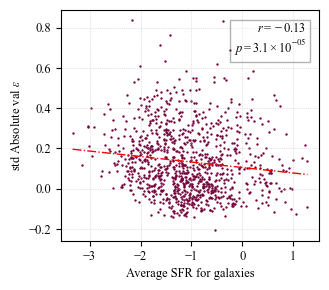

In [174]:
weighted_e = np.log(mean_e) - (slope * np.log(mean_SFR) + intercept)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10/3,3))
ax.grid(which='both', linestyle='dotted', linewidth=0.5, alpha=0.7)

ax.scatter(np.log(mean_SFR), weighted_e, c='xkcd:merlot', s=0.5)
slope, intercept = np.polyfit(np.log(mean_SFR), weighted_e, 1)
x_vals = np.linspace(min(np.log(mean_SFR)), max(np.log(mean_SFR)), 10)
y_vals = slope * x_vals + intercept
ax.plot(x_vals, y_vals, lw=1, color='red', linestyle='-.', label=f"Linear Fit")

pearson_coeff, p_value = pearsonr(np.log(mean_SFR), weighted_e)
if p_value:
    ax.text( 0.95, 0.95, 
    f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
    transform=ax.transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
    bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
    
    
ax.set_ylabel(r'mean log Absolute val $\epsilon$')
ax.set_xlabel(f'Average log(SFR) for galaxies')
# ax.set_xscale('log')
# ax.set_yscale('log')

In [ ]:
SF = np.where(filt_SFR!=0)[0]
print(len(SF)/len(filt_SFR))
NSF = np.where(filt_SFR==0)[0]

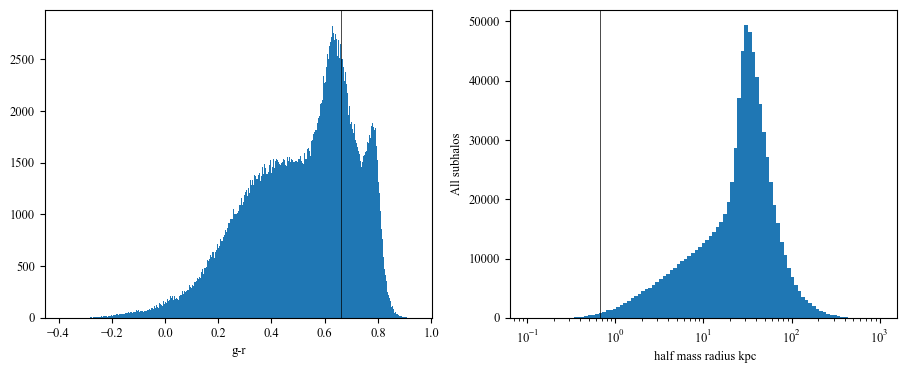

In [42]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(33/3,4))
ax[0].hist(filt_g_r,bins=1000)
ax[0].axvline(0.66,c='k',lw=0.5)
ax[0].set_xlabel('g-r')
ax[1].hist(filt_halfrad,bins=np.logspace(-1,3,100))
ax[1].axvline(0.66,c='k',lw=0.5)
ax[1].set_xlabel(' half mass radius kpc')
ax[1].set_ylabel('All subhalos')
ax[1].set_xscale('log')
plt.show()

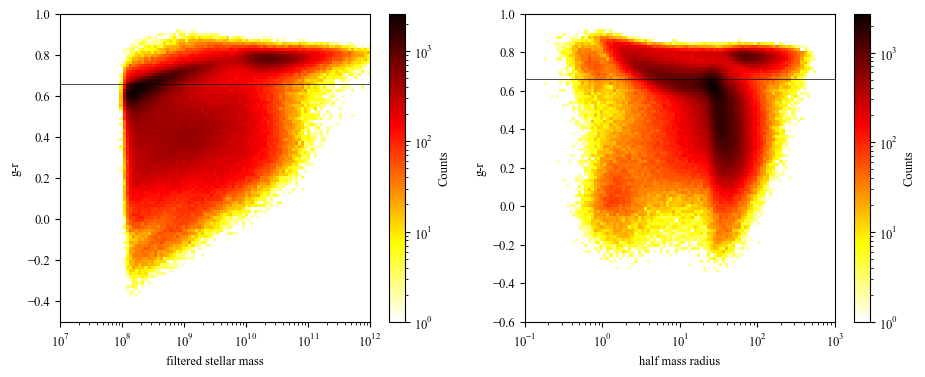

In [50]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(33/3,4))
# ax[0].scatter(filt_M_R_12, filt_g_r, s=0.01)
h = ax[0].hist2d(filt_M, filt_g_r, bins=(np.logspace(7,12,100),np.linspace(-0.5,1,100)), norm=mpl.colors.LogNorm(), cmap='hot_r')
ax[0].axhline(0.66,c='k',lw=0.5)
ax[0].set_xscale('log')
ax[0].set_ylabel('g-r')
ax[0].set_xlabel('filtered stellar mass')
cbar = fig.colorbar(h[3], ax=ax[0])
cbar.set_label("Counts")

h = ax[1].hist2d(filt_halfrad, filt_g_r, bins=(np.logspace(-1,3,100),np.linspace(-0.6,1,100)), norm=mpl.colors.LogNorm(), cmap='hot_r')
# ax[1].scatter(all_M_R_12, all_g_r, s=0.01)
ax[1].axhline(0.66,c='k',lw=0.5)
ax[1].set_xscale('log')
ax[1].set_ylabel('g-r')
ax[1].set_xlabel('half mass radius')
cbar = fig.colorbar(h[3], ax=ax[1])
cbar.set_label("Counts")


0.38336608856415555

In [24]:
print(np.mean(filt_g_r))

0.5120813766017127


-10.5

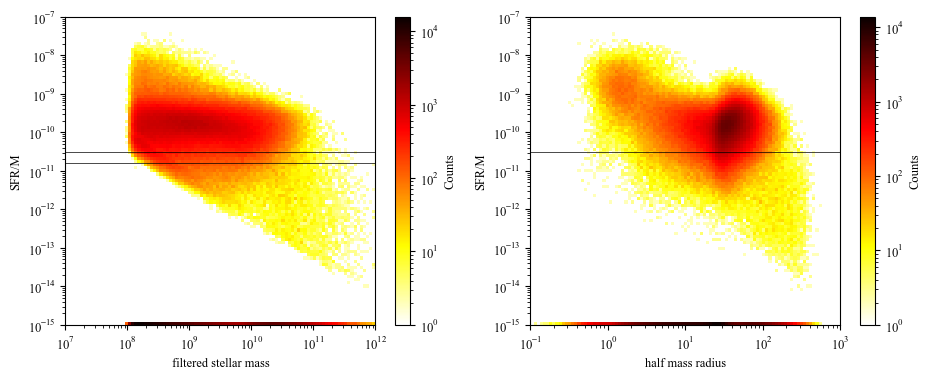

In [51]:
import matplotlib as mpl
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(33/3,4))
# Avoid division by zero by replacing zeros with a small positive value
epsilon = 1e-15
sfr_to_mass = np.where(filt_SFR / filt_M > 0, filt_SFR / filt_M, epsilon)


h = ax[0].hist2d(filt_M, sfr_to_mass, bins=(np.logspace(7,12,100), np.logspace(-15,-7,100)), norm=mpl.colors.LogNorm(), cmap='hot_r')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylabel('SFR/M')
ax[0].axhline(10**-10.5,c='k',lw=0.5)
ax[0].axhline(10**-10.8,c='k',lw=0.5)
ax[0].set_xlabel('filtered stellar mass')
cbar = fig.colorbar(h[3], ax=ax[0])
cbar.set_label("Counts")

h = ax[1].hist2d(filt_halfrad, sfr_to_mass, bins=(np.logspace(-1,3,100), np.logspace(-15,-7,100)), norm=mpl.colors.LogNorm(), cmap='hot_r')
# ax[1].scatter(all_M_R_12, all_g_r, s=0.01)
ax[1].axhline(10**-10.5,c='k',lw=0.5)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylabel('SFR/M')
ax[1].set_xlabel('half mass radius')
cbar = fig.colorbar(h[3], ax=ax[1])
cbar.set_label("Counts")

#### Split informaition

In [67]:
print("fraction of SSR=0 galaxies: - no gas left", sum((filt_SFR/filt_M)==0)/len(filt_SFR/filt_M))
print("fraction of galaxies with SSFR<10^{-10.5} - red galaxies", sum((filt_SFR/filt_M)<10**-10.5)/len(filt_SFR))
print(np.mean(split_fracs))
print(np.mean(mean_SFR), np.mean(mean_SFR_ell), np.mean(mean_SFR_spi))
print(np.mean(mean_SSFR), np.mean(mean_SSFR_ell), np.mean(mean_SSFR_spi))
print(np.mean(mean_g_r), np.mean(mean_g_r_ell), np.mean(mean_g_r_spi))
print()

print(f"{np.mean(mean_mass):.2e}", f"{np.mean(mean_mass_ell):.2e}", f"{np.mean(mean_mass_spi):.2e}")
print(np.mean(mean_e), np.mean(mean_e_ell), np.mean(mean_e_spi))
print(np.mean(std_e), np.mean(std_e_ell), np.mean(std_e_spi))

fraction of SSR=0 galaxies: - no gas left 0.38336608856415555
fraction of galaxies with SSFR<10^{-10.5} - red galaxies 0.4585529997438658
0.8665594888884655
0.47740096897631884 0.04277080859756097 0.7005114482492208
2.0180353839903408e-10 3.180125471389118e-12 3.057844920259512e-10
0.47744701911509035 0.6421919974386692 0.3722800068855286

8.04e+09 1.32e+10 3.70e+09
0.21574561424753083 0.23072036864241552 0.20678695464744465
0.2099100158036692 0.24634914641640712 0.178799055607874


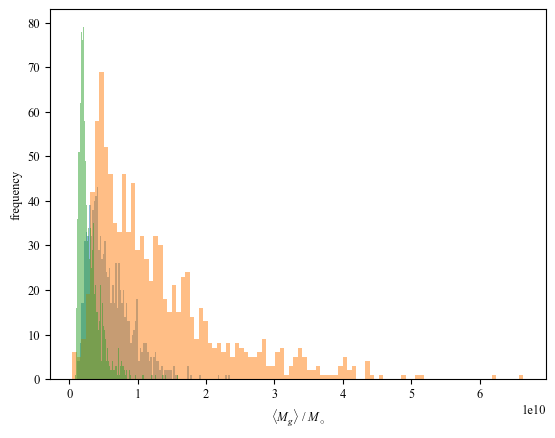

In [213]:
plt.hist(mean_mass, bins=100,alpha=0.5, label='all')
plt.hist(mean_mass_ell, bins=100,alpha=0.5, label='$sSFR < 10^{-10.5}$ /yr')
plt.hist(mean_mass_spi, bins=100,alpha=0.5, label='$sSFR > 10^{-10.5}$ /yr')
plt.xlabel(r'$\langle M_g \rangle$ / $M_\circ$'); plt.ylabel('frequency')
plt.savefig('/Users/danie/Library/CloudStorage/OneDrive-Personal/Physics UCL/Year 3/Astro Research Project 2023/mean masses.pdf',dpi=300)
plt.show()

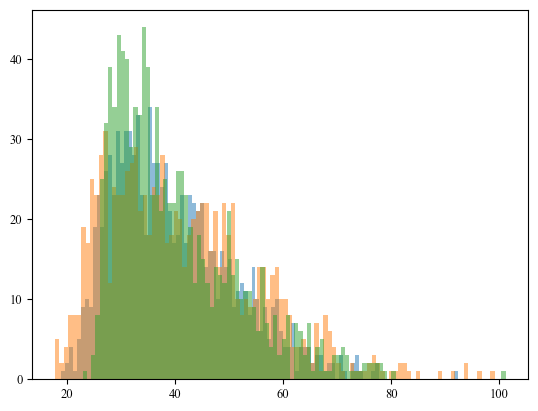

In [207]:
plt.hist(mean_halfrad, bins=100,alpha=0.5)
plt.hist(mean_halfrad_ell, bins=100,alpha=0.5)
plt.hist(mean_halfrad_spi, bins=100,alpha=0.5)
plt.show()

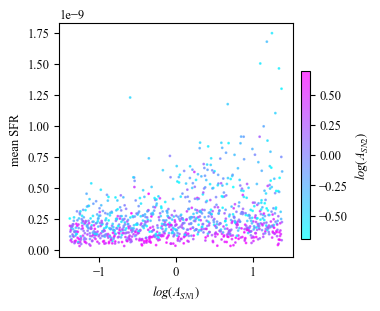

In [27]:
import matplotlib as mpl
param=2
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10/3,3))
scatter = ax.scatter(label_table[:,param], mean_SSFR, s=1, c=label_table[:,4], cmap=mpl.cm.cool,alpha=0.7,label="")
ax.set_xlabel(f'${simpars[param]}$')
ax.set_ylabel(f'mean SFR')
cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', shrink=0.8, pad=0.02)
cbar.set_label('$log(A_{SN2})$', fontsize=9)
fig.set_constrained_layout(True)

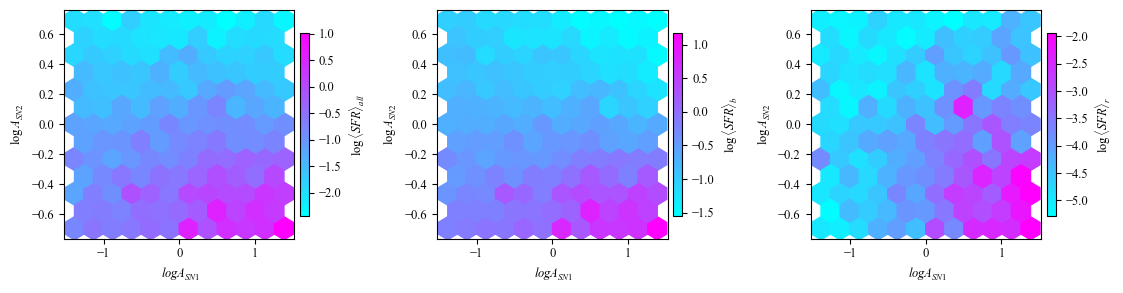

In [161]:
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(34/3,3))
hb = ax[0].hexbin(
    label_table[:, 2], label_table[:, 4], 
    C=np.log(mean_SFR), 
    gridsize=11,  # Adjust the resolution of the bins
    cmap=mpl.cm.cool, 
    reduce_C_function=np.mean  # Aggregate using the mean value of log(SFR) within each bin
)
ax[0].set_xlabel(f'${simpars[2]}$')
ax[0].set_ylabel(f'${simpars[4]}$')
cbar = fig.colorbar(hb, ax=ax[0], orientation='vertical', shrink=0.8, pad=0.02)
cbar.set_label(r'$\log\langle SFR \rangle_{all}$ ', fontsize=9)

hb = ax[1].hexbin(
    label_table[:, 2], label_table[:, 4], 
    C=np.log(mean_SFR_spi), 
    gridsize=11,  # Adjust the resolution of the bins
    cmap=mpl.cm.cool, 
    reduce_C_function=np.mean  # Aggregate using the mean value of log(SFR) within each bin
)
ax[1].set_xlabel(f'${simpars[2]}$')
ax[1].set_ylabel(f'${simpars[4]}$')
cbar = fig.colorbar(hb, ax=ax[1], orientation='vertical', shrink=0.8, pad=0.02)
cbar.set_label(r'$\log\langle SFR \rangle_b$', fontsize=9)

hb = ax[2].hexbin(
    label_table[:, 2], label_table[:, 4], 
    C=np.log(mean_SFR_ell), 
    gridsize=11,  # Adjust the resolution of the bins
    cmap=mpl.cm.cool, 
    reduce_C_function=np.mean  # Aggregate using the mean value of log(SFR) within each bin
)
ax[2].set_xlabel(f'${simpars[2]}$')
ax[2].set_ylabel(f'${simpars[4]}$')
cbar = fig.colorbar(hb, ax=ax[2], orientation='vertical', shrink=0.8, pad=0.02)
cbar.set_label(r'$\log \langle SFR \rangle_r$ ', fontsize=9)

fig.tight_layout()
plt.savefig('/Users/danie/Library/CloudStorage/OneDrive-Personal/Physics UCL/Year 3/Astro Research Project 2023/SSFR A_SN1 A_SN2.pdf',
    dpi=300, bbox_inches='tight')

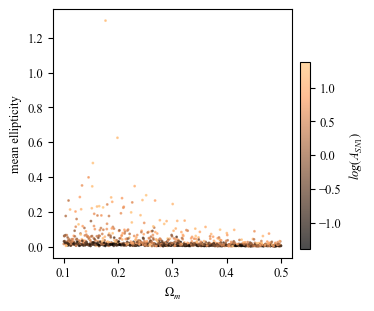

In [36]:
param=0
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10/3,3))
scatter = ax.scatter(label_table[:,param], mean_SFR_ell, s=1, c=label_table[:,2], cmap=mpl.cm.copper,alpha=0.7,label="")
ax.set_xlabel(f'${simpars[param]}$')
ax.set_ylabel(f'mean ellipticity')
cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', shrink=0.8, pad=0.02)
cbar.set_label('$log(A_{SN1})$', fontsize=9)
fig.set_constrained_layout(True)

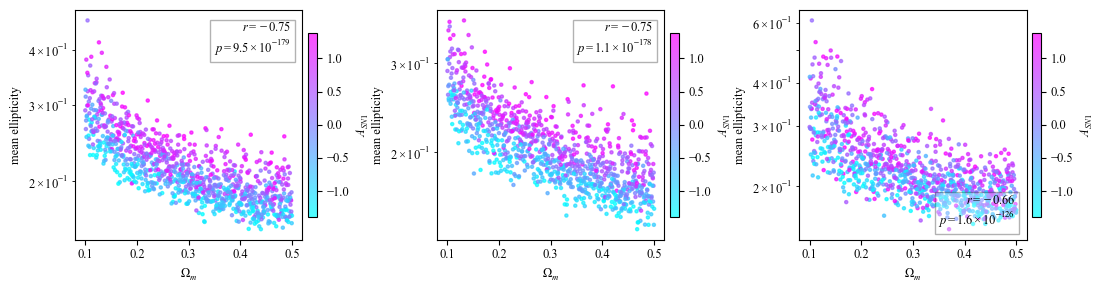

In [55]:
param=0
def plotCB(param,y1,y2,y3,c1,c2,c3,y1label=f'SSFR /yr',y2label=f'SSFR /yr',y3label=f'SSFR /yr',
           c1label=r'$log(\langle\epsilon\rangle)$', c2label=r'$log(\langle\epsilon\rangle)$', c3label=r'$log(\langle\epsilon\rangle)$'):
    global cbar2, cbar3
    fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(33/3,3))
    scatter = ax[0].scatter(label_table[:,param], y1, s=5, c=c1, cmap=mpl.cm.cool,alpha=0.7,label="")
    ax[0].set_xlabel(f'${simpars[param]}$')
    ax[0].set_ylabel(y1label)
    cbar = fig.colorbar(scatter, ax=ax[0], orientation='vertical', shrink=0.8, pad=0.02)
    cbar.set_label(c1label, fontsize=9)
    pearson_coeff, p_value = pearsonr(label_table[:,param], y1)
    if p_value:
        ax[0].text( 0.95, 0.95, 
        f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
        transform=ax[0].transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
    scatter = ax[1].scatter(label_table[:,param], y2, s=5, c=c2, cmap=mpl.cm.cool,alpha=0.7,label="")
    ax[1].set_xlabel(f'${simpars[param]}$')
    ax[1].set_ylabel(y2label)
    cbar2 = fig.colorbar(scatter, ax=ax[1], orientation='vertical', shrink=0.8, pad=0.02)
    cbar2.set_label(c2label, fontsize=9)
    pearson_coeff, p_value = pearsonr(label_table[:,param], y2)
    if p_value:
        ax[1].text( 0.95, 0.95, 
        f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
        transform=ax[1].transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
    scatter = ax[2].scatter(label_table[:,param], y3, s=5, c=c3, cmap=mpl.cm.cool,alpha=0.7,label="")
    ax[2].set_xlabel(f'${simpars[param]}$')
    ax[2].set_ylabel(y3label)
    cbar3 = fig.colorbar(scatter, ax=ax[2], orientation='vertical', shrink=0.8, pad=0.02)
    cbar3.set_label(c3label, fontsize=9)
    pearson_coeff, p_value = pearsonr(label_table[:,param], y3)
    if p_value:
        ax[2].text( 0.95, 0.2, 
        f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
        transform=ax[2].transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
    plt.tight_layout()
    ax[0].set_yscale('log'); ax[1].set_yscale('log'); ax[2].set_yscale('log')
plotCB(0, mean_e, mean_e_spi, mean_e_ell, label_table[:,2], label_table[:,2], label_table[:,2], 
       y1label=f'mean ellipticity',y2label=f'mean ellipticity', y3label=f'mean ellipticity',
       c1label=r'$A_{SN1}$', c2label=r'$A_{SN1}$', c3label=r'$A_{SN1}$')

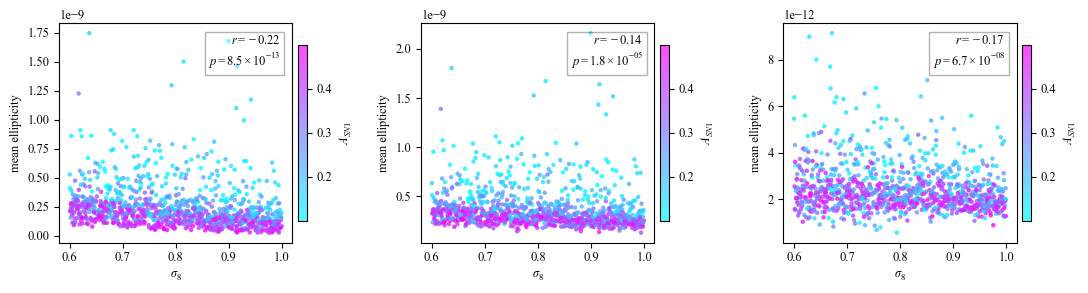

In [41]:
plotCB(1, mean_SSFR, mean_SSFR_spi, mean_SSFR_ell, label_table[:,0], label_table[:,0], label_table[:,0], 
       ylabel=f'mean ellipticity', clabel=r'$A_{SN1}$')

In [221]:
print(np.mean(mean_e), np.mean(mean_e_spi), np.mean(mean_e_ell))
print(np.std(mean_e), np.std(mean_e_spi), np.std(mean_e_ell))

0.21574744640381852 0.13862997770667057 0.5952280881469957
0.03995074236174389 0.03719506362848142 0.060381510924753676


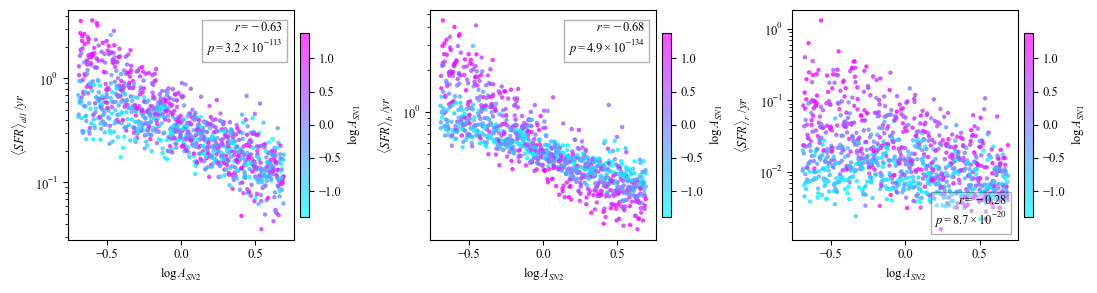

In [202]:
plotCB(4, mean_SFR, mean_SFR_spi, mean_SFR_ell, label_table[:,2], label_table[:,2], label_table[:,2], 
       y1label=r'$ \langle SFR \rangle_{all}$ $/yr$', c1label=r'$\log A_{SN1}$', 
       y2label=r'$ \langle SFR \rangle_{b}$ $/yr$', c2label=r'$\log A_{SN1}$',
       y3label=r'$ \langle SFR \rangle_{r}$ $/yr$', c3label=r'$\log A_{SN1}$')
       

plt.savefig('/Users/danie/Library/CloudStorage/OneDrive-Personal/Physics UCL/Year 3/Astro Research Project 2023/SFR A_SN2 A_SN1.pdf',
    dpi=300, bbox_inches='tight')


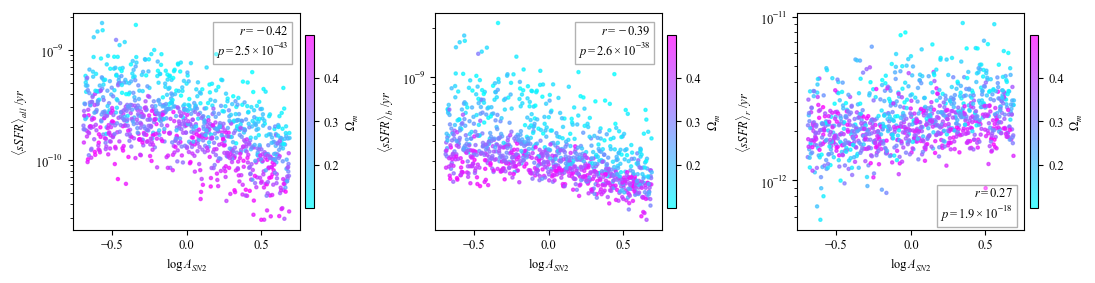

In [203]:
plotCB(4, mean_SSFR, mean_SSFR_spi, mean_SSFR_ell, label_table[:,0], label_table[:,0], label_table[:,0], 
       y1label=r'$ \langle sSFR \rangle_{all}$ $/yr$', c1label=r'$\Omega_m$', 
       y2label=r'$ \langle sSFR \rangle_{b}$ $/yr$', c2label=r'$\Omega_m$',
       y3label=r'$ \langle sSFR \rangle_{r}$ $/yr$', c3label=r'$ \Omega_m$')
plt.savefig('/Users/danie/Library/CloudStorage/OneDrive-Personal/Physics UCL/Year 3/Astro Research Project 2023/SSFR A_SN2 \Omega_m.pdf',
    dpi=300, bbox_inches='tight')

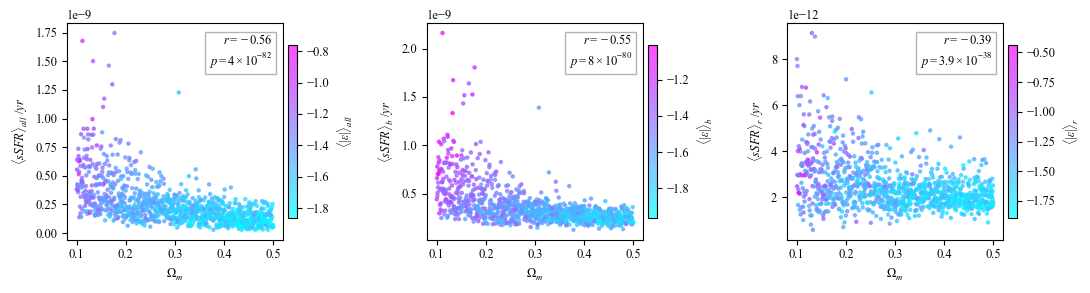

In [151]:
plotCB(0, mean_SSFR, mean_SSFR_spi, mean_SSFR_ell, np.log(mean_e), np.log(mean_e_spi), np.log(mean_e_ell), 
       y1label=r'$\langle sSFR \rangle_{all}$ $/yr$', c1label=r'$\langle |\epsilon|\rangle_{all}$', 
       y2label=r'$\langle sSFR \rangle_{b}$ $/yr$', c2label=r'$\langle |\epsilon|\rangle_{b}$',
       y3label=r'$\langle sSFR \rangle_{r}$ $/yr$', c3label=r'$\langle |\epsilon|\rangle_{r}$', )


plt.savefig('/Users/danie/Library/CloudStorage/OneDrive-Personal/Physics UCL/Year 3/Astro Research Project 2023/SSFR \Omega_m e.pdf',
    dpi=300, bbox_inches='tight')

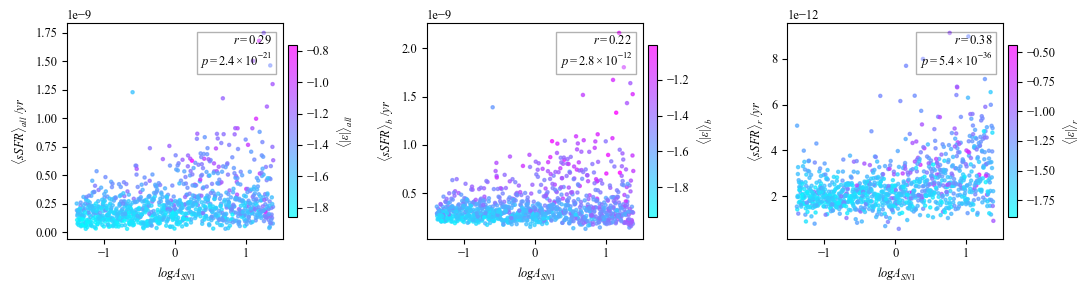

In [152]:
plotCB(2, mean_SSFR, mean_SSFR_spi, mean_SSFR_ell,np.log(mean_e), np.log(mean_e_spi), np.log(mean_e_ell), 
       y1label=r'$\langle sSFR \rangle_{all}$ $/yr$', c1label=r'$\langle |\epsilon|\rangle_{all}$', 
       y2label=r'$\langle sSFR \rangle_{b}$ $/yr$', c2label=r'$\langle |\epsilon|\rangle_{b}$',
       y3label=r'$\langle sSFR \rangle_{r}$ $/yr$', c3label=r'$\langle |\epsilon|\rangle_{r}$', )
plt.savefig('/Users/danie/Library/CloudStorage/OneDrive-Personal/Physics UCL/Year 3/Astro Research Project 2023/SSFR A_SN1 e.pdf',
    dpi=300, bbox_inches='tight')

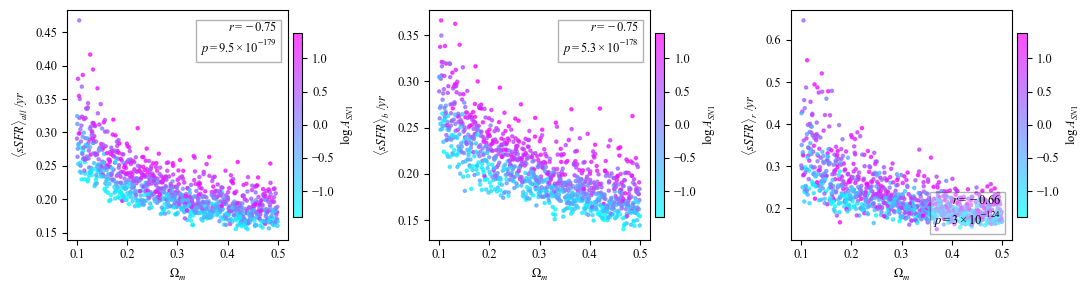

In [191]:
plotCB(0, mean_e, mean_e_spi, mean_e_ell,  label_table[:,2], label_table[:,2], label_table[:,2], 
       y1label=r'$\langle sSFR \rangle_{all}$ $/yr$', c1label=r'$\log A_{SN1}$', 
       y2label=r'$\langle sSFR \rangle_{b}$ $/yr$', c2label=r'$\log A_{SN1}$',
       y3label=r'$\langle sSFR \rangle_{r}$ $/yr$', c3label=r'$\log A_{SN1}$', )

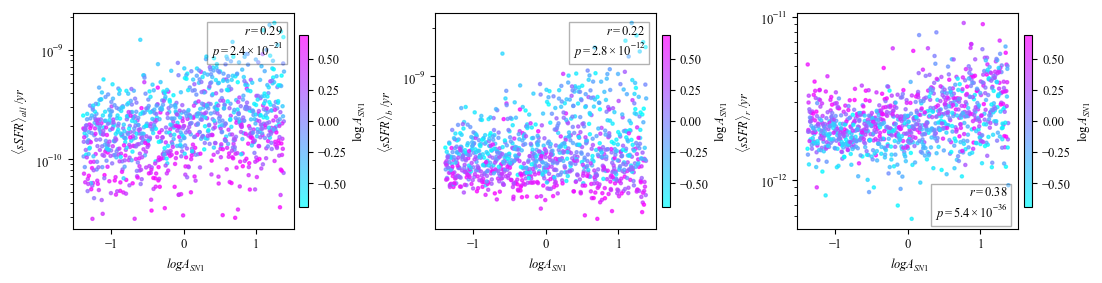

In [8]:
plotCB(2, mean_SSFR, mean_SSFR_spi, mean_SSFR_ell,  label_table[:,4], label_table[:,4], label_table[:,4], 
       y1label=r'$\langle sSFR \rangle_{all}$ $/yr$', c1label=r'$\log A_{SN1}$', 
       y2label=r'$\langle sSFR \rangle_{b}$ $/yr$', c2label=r'$\log A_{SN1}$',
       y3label=r'$\langle sSFR \rangle_{r}$ $/yr$', c3label=r'$\log A_{SN1}$', )

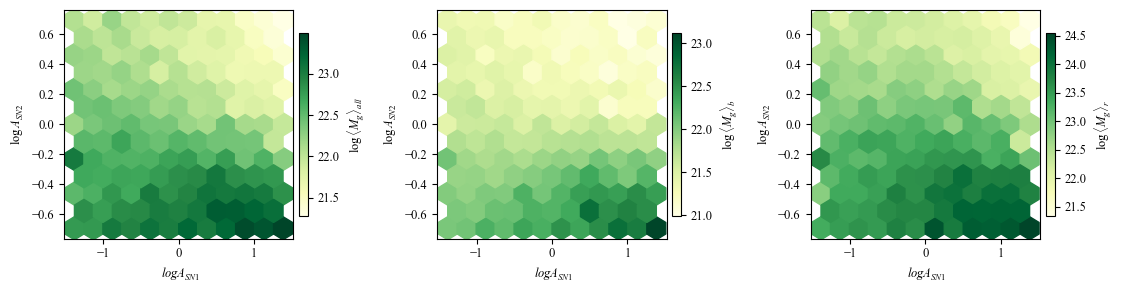

In [198]:
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(34/3,3))
hb = ax[0].hexbin(
    label_table[:, 2], label_table[:, 4], 
    C=np.log(mean_mass), 
    gridsize=11,  # Adjust the resolution of the bins
    cmap=mpl.cm.YlGn, 
    reduce_C_function=np.mean  # Aggregate using the mean value of log(SFR) within each bin
)
ax[0].set_xlabel(f'${simpars[2]}$')
ax[0].set_ylabel(f'${simpars[4]}$')
cbar = fig.colorbar(hb, ax=ax[0], orientation='vertical', shrink=0.8, pad=0.02)
cbar.set_label(r'$\log\langle M_g \rangle_{all}$ ', fontsize=9)

hb = ax[1].hexbin(
    label_table[:, 2], label_table[:, 4], 
    C=np.log(mean_mass_spi), 
    gridsize=11,  # Adjust the resolution of the bins
    cmap=mpl.cm.YlGn, 
    reduce_C_function=np.mean  # Aggregate using the mean value of log(SFR) within each bin
)
ax[1].set_xlabel(f'${simpars[2]}$')
ax[1].set_ylabel(f'${simpars[4]}$')
cbar = fig.colorbar(hb, ax=ax[1], orientation='vertical', shrink=0.8, pad=0.02)
cbar.set_label(r'$\log\langle M_g \rangle_b$', fontsize=9)

hb = ax[2].hexbin(
    label_table[:, 2], label_table[:, 4], 
    C=np.log(mean_mass_ell), 
    gridsize=11,  # Adjust the resolution of the bins
    cmap=mpl.cm.YlGn, 
    reduce_C_function=np.mean  # Aggregate using the mean value of log(SFR) within each bin
)
ax[2].set_xlabel(f'${simpars[2]}$')
ax[2].set_ylabel(f'${simpars[4]}$')
cbar = fig.colorbar(hb, ax=ax[2], orientation='vertical', shrink=0.8, pad=0.02)
cbar.set_label(r'$\log \langle M_g \rangle_r$ ', fontsize=9)

fig.tight_layout()

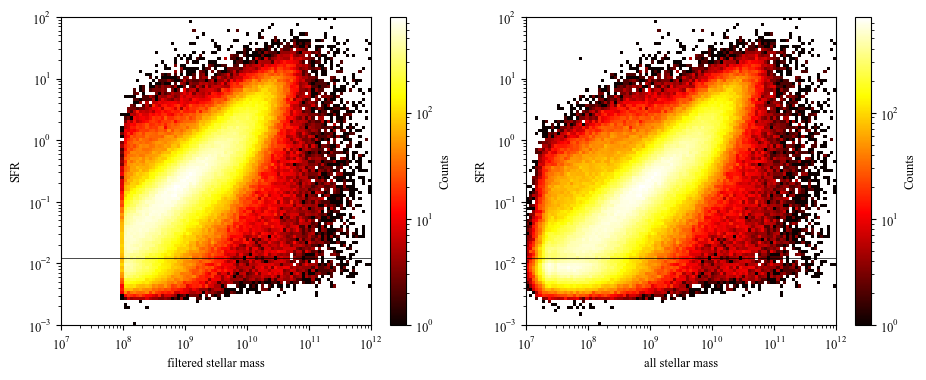

In [83]:
import matplotlib as mpl
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(33/3,4))
# ax[0].scatter(filt_M_R_12, filt_g_r, s=0.01)
h = ax[0].hist2d(filt_M_R_12, filt_SFR, bins=(np.logspace(7,12,100),np.logspace(-3,2,100)), norm=mpl.colors.LogNorm(), cmap='hot')
ax[0].axhline(0.012,c='k',lw=0.5)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylabel('SFR')
ax[0].set_xlabel('filtered stellar mass')
cbar = fig.colorbar(h[3], ax=ax[0])
cbar.set_label("Counts")

h = ax[1].hist2d(all_M_R_12, all_SFR, bins=(np.logspace(7,12,100),np.logspace(-3,2,100)), norm=mpl.colors.LogNorm(), cmap='hot')
# ax[1].scatter(all_M_R_12, all_g_r, s=0.01)
ax[1].axhline(0.012,c='k',lw=0.5)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylabel('SFR')
ax[1].set_xlabel('all stellar mass')
cbar = fig.colorbar(h[3], ax=ax[1])
cbar.set_label("Counts")

In [28]:
SF_ = np.where(all_SFR!=0)[0]
print("Fraction of all Galaxies with SFR",len(SF_)/len(all_SFR))
NSF_ = np.where(all_SFR==0)[0]

SF = np.where(filt_SFR!=0)[0]
print("Fraction of my galaxies with SFR",len(SF)/len(filt_SFR))
NSF = np.where(filt_SFR==0)[0]
print(sum(filt_SFR<0.012)/len(filt_SFR))

Fraction of all Galaxies with SFR 0.044639033337640285
Fraction of my galaxies with SFR 0.6166339114358445
0.4274296632503305


Text(0, 0.5, 'n stars')

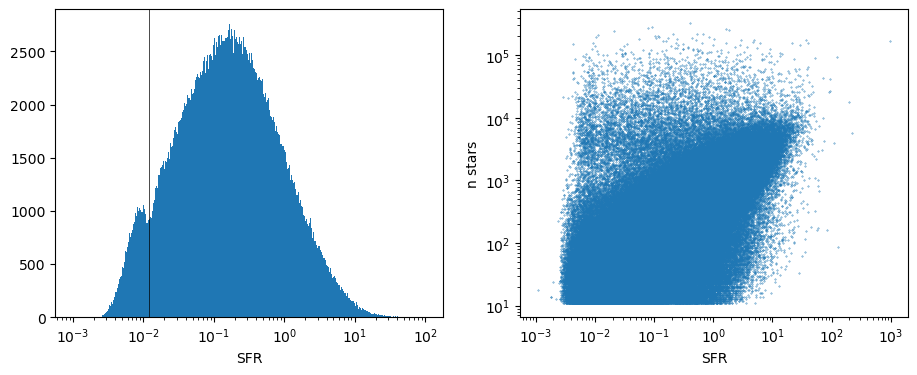

In [21]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(33/3,4))

ax[0].hist(filt_SFR[SF],bins=np.logspace(0-3,2,500))
ax[0].axvline(0.012,c='k',lw=0.5)
ax[0].set_xscale('log')
ax[0].set_xlabel('SFR')
ax[1].scatter(filt_SFR[SF], filt_nstar[SF] , s=0.1)
# plt.hist2d(all_SFR[filt] , all_M_R_12[filt],cmap='bone',bins=np.logspace(0-4,3,50))
ax[1].set_xscale('log'); ax[1].set_yscale('log')
# plt.xlim([-1,10])
plt.xlabel('SFR'); plt.ylabel('n stars')

In [78]:
print(len(filt_M_R_12), len(all_M_R_12),len(all_SFR), len(filt_M_R_12),len(all_nstar), len(filt_nstar) )

823787 16879689 16879689 823787 16879689 823787


Filter out 95.12% of subhalos. and 1 - 504388/748761 = 32.26% of subhalos with non-zero SFR

In [171]:
SF_ = np.where(all_SFR!=0)[0]
print(len(SF_)/len(all_SFR))
NSF_ = np.where(all_SFR==0)[0]

0.044639033337640285


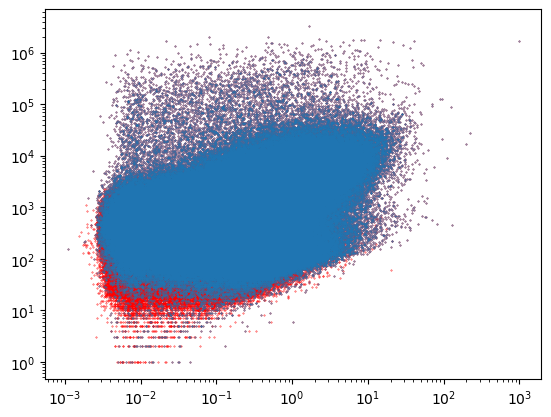

In [187]:
plt.scatter(all_SFR[SF_], all_gas[SF_] , s=0.1,c='red')
plt.scatter(filt_SFR[SF], filt_gas[SF] , s=0.1)
# plt.hist2d(all_SFR , all_gas,cmap='bone',bins=(np.logspace(1e-6,5,256),np.logspace(1e-6,2e6,256)))
plt.xscale('log'); plt.yscale('log')
# plt.xlim([-0.1,5]); plt.ylim([-1e5,2e6])

In [169]:
print(len(all_SFR),len(filt_SFR[SF]))

16879689 507975


In [2]:
# Function to convert Cartesian coordinates to spherical coordinates
def cart_to_spherical(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    # make it so z is parallel to line of sight of observer
    theta = np.arccos(x / r)
    phi = np.arctan2(y, z)
    return r, theta, phi

# Function to convert spherical coordinates to RA and DEC in degrees
def spherical_to_ra_dec(theta, phi):
    ra = np.degrees(phi)
    dec = 90 - np.degrees(theta)
    return ra, dec

### Making Spiral/Elliptical catalogues 

In [14]:
axis = 'q'
print(f'abcd{axis}ef')

abcdqef


In [8]:
axis = 'x'
for filenum in range(0,1000):
    CAT = f'/Volumes/CAMELSDrive/Illustris_SUBFIND/LH{filenum}_SUBFIND.hdf5'
    # open 
    f = h5py.File(CAT, 'r')

    pos_sh  = f['Subhalo/SubhaloPos'][:]/1e3     #positions of SUBFIND subhalos in Mpc/h
    SFR_sh = f['Subhalo/SubhaloSFR'][:]
    mass_sh = f['Subhalo/SubhaloMassType'][:,4]*1e10
#     nstar_sh = f['Subhalo/SubhaloLenType'][:,4]
#     ngas_sh = f['Subhalo/SubhaloLenType'][:,0]
    # close file
    f.close()

    fits_file_path = f'LH_ellipticities/CAMELS_data_LH{axis}{filenum}.fits'

    with fits.open(fits_file_path) as hdul:
        data = hdul[1].data

    if axis == 'x':
        pos_sh = np.array([pos_sh[:,1],pos_sh[:,2],pos_sh[:,0]]).T # Axis change
    elif axis == 'y':
        pos_sh = np.array([pos_sh[:,2],pos_sh[:,0],pos_sh[:,1]]).T # Axis change
    # Now you can use the same variable names
    pos_g = np.array([data['x'], data['y'], data['z']]).T
    ias = np.array([data['ia_1'], data['ia_2']]).T

    indices = np.where((pos_sh[:, None] == pos_g).all(axis=2).any(axis=1))[0]
    consistent = pos_g.shape[0]==indices.shape[0]
#     print(indices.shape[0],"=",pos_g.shape[0]," ",consistent)
    # filter out elliptical
    if consistent:

#         non_zero = SFR_sh[indices] > -10 #!=0

#         nz_pos = pos_g[non_zero]
#         nz_shape = ias[non_zero]
        SFR_g = SFR_sh[indices] #  galaxy SFR and Mass
        mass_g = mass_sh[indices]

        split = 10**-10.5
        elliptical = (SFR_g/mass_g)<split
        spiral = (SFR_g/mass_g)>=split
        
        ell_pos = pos_g[elliptical]
        ell_shapes = ias[elliptical]
        
        spi_pos = pos_g[spiral]
        spi_shapes = ias[spiral]

        print(filenum, spi_shapes.shape, ell_shapes.shape)
        
        ################## SPIRALS
        
        x = spi_pos[:,0]
        y = spi_pos[:,1]
        z = spi_pos[:,2]
        ia_1 = spi_shapes[:,0]
        ia_2 = spi_shapes[:,1]


        z+= 10000

        r, theta, phi = cart_to_spherical(x, y, z)
        ra, dec = spherical_to_ra_dec(theta, phi)
        
        # Create a FITS table
        data = fits.BinTableHDU.from_columns([
            fits.Column(name='RA', format='D', array=ra),
            fits.Column(name='DEC', format='D', array=dec),
            fits.Column(name='r_col', format='D', array=r),
            fits.Column(name='ia_1', format='D', array=ia_1),
            fits.Column(name='ia_2', format='D', array=ia_2),
        ])

        primary_hdu = fits.PrimaryHDU()
        hdul = fits.HDUList([primary_hdu, data])

        # Save the FITS file
        hdul.writeto(f'../correlating-folder/LH_ellipticities_RADEC_spirals/CAMELS_proj_data_LH{axis}{filenum}.fits', overwrite=True)
        
#         fits_file_path = f'LH_ellipticities_RADEC/CAMELS_proj_rand_LH{axis}{filenum}.fits'

#         with fits.open(fits_file_path) as hdul:
#             data = hdul[1].data

#         # Now you can use the same variable names
#         ra_rand = data['RA']
#         dec_rand = data['DEC']
#         r_rand = data['r_col']
        
#         ra_rand2 = ra_rand[spiral]
#         dec_rand2 = dec_rand[spiral]
#         r_rand2 = r_rand[spiral]
        x_rand, y_rand, z_rand = np.random.uniform(0, 25, (3,len(x)))
        ia_1_rand, ia_2_rand = np.random.normal(loc=0, scale=0.14, size=(2,len(x)))
        
        z_rand += 10000

        r_rand, theta, phi = cart_to_spherical(x_rand, y_rand, z_rand)
        ra_rand, dec_rand = spherical_to_ra_dec(theta, phi)
        
        # Create a FITS table
        data = fits.BinTableHDU.from_columns([
            fits.Column(name='RA', format='D', array=ra_rand),
            fits.Column(name='DEC', format='D', array=dec_rand),
            fits.Column(name='r_col', format='D', array=r_rand)
        ])

        # Create a Primary HDU
        primary_hdu = fits.PrimaryHDU()
        hdul = fits.HDUList([primary_hdu, data])

        # Save the FITS file
        hdul.writeto(f'../correlating-folder/LH_ellipticities_RADEC_spirals/CAMELS_proj_rand_LH{axis}{filenum}.fits', overwrite=True)
        
        ################ ELLIPTICALS
                
        x = ell_pos[:,0]
        y = ell_pos[:,1]
        z = ell_pos[:,2]
        ia_1 = ell_shapes[:,0]
        ia_2 = ell_shapes[:,1]


        z+= 10000
        r, theta, phi = cart_to_spherical(x, y, z)
        ra, dec = spherical_to_ra_dec(theta, phi)
        

        data = fits.BinTableHDU.from_columns([
            fits.Column(name='RA', format='D', array=ra),
            fits.Column(name='DEC', format='D', array=dec),
            fits.Column(name='r_col', format='D', array=r),
            fits.Column(name='ia_1', format='D', array=ia_1),
            fits.Column(name='ia_2', format='D', array=ia_2),
        ])

        primary_hdu = fits.PrimaryHDU()
        hdul = fits.HDUList([primary_hdu, data])

        # Save the FITS file
        hdul.writeto(f'../correlating-folder/LH_ellipticities_RADEC_ellipticals/CAMELS_proj_data_LH{axis}{filenum}.fits', overwrite=True)
        
#         fits_file_path = f'LH_ellipticities_RADEC/CAMELS_proj_rand_LH{axis}{filenum}.fits'

#         with fits.open(fits_file_path) as hdul:
#             data = hdul[1].data

#         # Now you can use the same variable names
#         ra_rand = data['RA']
#         dec_rand = data['DEC']
#         r_rand = data['r_col']
        
#         ra_rand2 = ra_rand[elliptical]
#         dec_rand2 = dec_rand[elliptical]
#         r_rand2 = r_rand[elliptical]
        x_rand, y_rand, z_rand = np.random.uniform(0, 25, (3,len(x)))
        ia_1_rand, ia_2_rand = np.random.normal(loc=0, scale=0.14, size=(2,len(x)))
        
        z_rand += 10000
        r_rand, theta, phi = cart_to_spherical(x_rand, y_rand, z_rand)
        ra_rand, dec_rand = spherical_to_ra_dec(theta, phi)
        
        # Create a FITS table
        data = fits.BinTableHDU.from_columns([
            fits.Column(name='RA', format='D', array=ra_rand),
            fits.Column(name='DEC', format='D', array=dec_rand),
            fits.Column(name='r_col', format='D', array=r_rand)
        ])

        primary_hdu = fits.PrimaryHDU()
        hdul = fits.HDUList([primary_hdu, data])

        # Save the FITS file
        hdul.writeto(f'../correlating-folder/LH_ellipticities_RADEC_ellipticals/CAMELS_proj_rand_LH{axis}{filenum}.fits', overwrite=True)
        

    else:
        print('Not consistent')
        break


0 (285, 2) (124, 2)
1 (215, 2) (133, 2)
2 (351, 2) (819, 2)
3 (307, 2) (42, 2)
4 (283, 2) (75, 2)
5 (325, 2) (158, 2)
6 (257, 2) (260, 2)
7 (415, 2) (282, 2)
8 (428, 2) (1359, 2)
9 (737, 2) (781, 2)
10 (346, 2) (1186, 2)
11 (101, 2) (283, 2)
12 (231, 2) (390, 2)
13 (529, 2) (769, 2)
14 (289, 2) (87, 2)
15 (481, 2) (191, 2)
16 (271, 2) (126, 2)
17 (127, 2) (11, 2)
18 (210, 2) (32, 2)
19 (499, 2) (284, 2)
20 (627, 2) (510, 2)
21 (626, 2) (1049, 2)
22 (454, 2) (204, 2)
23 (335, 2) (150, 2)
24 (643, 2) (321, 2)
25 (284, 2) (98, 2)
26 (315, 2) (339, 2)
27 (570, 2) (288, 2)
28 (663, 2) (1127, 2)
29 (499, 2) (222, 2)
30 (236, 2) (116, 2)
31 (87, 2) (328, 2)
32 (502, 2) (1137, 2)
33 (278, 2) (79, 2)
34 (221, 2) (532, 2)
35 (559, 2) (632, 2)
36 (459, 2) (238, 2)
37 (201, 2) (308, 2)
38 (306, 2) (177, 2)
39 (209, 2) (71, 2)
40 (155, 2) (100, 2)
41 (368, 2) (1032, 2)
42 (345, 2) (154, 2)
43 (118, 2) (23, 2)
44 (311, 2) (75, 2)
45 (234, 2) (88, 2)
46 (373, 2) (335, 2)
47 (637, 2) (400, 2)
48 (487,

379 (322, 2) (433, 2)
380 (330, 2) (154, 2)
381 (167, 2) (55, 2)
382 (602, 2) (553, 2)
383 (344, 2) (202, 2)
384 (164, 2) (130, 2)
385 (290, 2) (141, 2)
386 (163, 2) (240, 2)
387 (279, 2) (661, 2)
388 (145, 2) (55, 2)
389 (473, 2) (468, 2)
390 (165, 2) (456, 2)
391 (624, 2) (254, 2)
392 (575, 2) (702, 2)
393 (224, 2) (1300, 2)
394 (221, 2) (26, 2)
395 (450, 2) (724, 2)
396 (514, 2) (1344, 2)
397 (205, 2) (138, 2)
398 (324, 2) (60, 2)
399 (434, 2) (1043, 2)
400 (465, 2) (209, 2)
401 (886, 2) (649, 2)
402 (370, 2) (203, 2)
403 (519, 2) (280, 2)
404 (371, 2) (565, 2)
405 (700, 2) (892, 2)
406 (521, 2) (570, 2)
407 (362, 2) (250, 2)
408 (322, 2) (80, 2)
409 (661, 2) (272, 2)
410 (269, 2) (658, 2)
411 (551, 2) (590, 2)
412 (246, 2) (249, 2)
413 (590, 2) (302, 2)
414 (625, 2) (229, 2)
415 (707, 2) (1026, 2)
416 (413, 2) (88, 2)
417 (775, 2) (487, 2)
418 (455, 2) (252, 2)
419 (468, 2) (1633, 2)
420 (912, 2) (526, 2)
421 (375, 2) (337, 2)
422 (642, 2) (960, 2)
423 (727, 2) (306, 2)
424 (596, 2

754 (472, 2) (1297, 2)
755 (254, 2) (225, 2)
756 (264, 2) (71, 2)
757 (602, 2) (653, 2)
758 (818, 2) (522, 2)
759 (399, 2) (137, 2)
760 (551, 2) (238, 2)
761 (279, 2) (79, 2)
762 (320, 2) (131, 2)
763 (317, 2) (80, 2)
764 (342, 2) (84, 2)
765 (182, 2) (414, 2)
766 (427, 2) (249, 2)
767 (339, 2) (88, 2)
768 (391, 2) (292, 2)
769 (762, 2) (446, 2)
770 (428, 2) (216, 2)
771 (792, 2) (759, 2)
772 (435, 2) (1075, 2)
773 (159, 2) (162, 2)
774 (457, 2) (574, 2)
775 (493, 2) (71, 2)
776 (151, 2) (61, 2)
777 (190, 2) (175, 2)
778 (712, 2) (494, 2)
779 (287, 2) (243, 2)
780 (709, 2) (543, 2)
781 (433, 2) (752, 2)
782 (287, 2) (48, 2)
783 (343, 2) (357, 2)
784 (847, 2) (429, 2)
785 (896, 2) (381, 2)
786 (380, 2) (540, 2)
787 (460, 2) (629, 2)
788 (364, 2) (194, 2)
789 (513, 2) (702, 2)
790 (700, 2) (256, 2)
791 (339, 2) (56, 2)
792 (251, 2) (367, 2)
793 (500, 2) (215, 2)
794 (558, 2) (432, 2)
795 (426, 2) (110, 2)
796 (972, 2) (545, 2)
797 (474, 2) (875, 2)
798 (526, 2) (231, 2)
799 (285, 2) (309

In [4]:
mean_e = 0.22161486140744618

### Making Spiral/elliptical cataloges ellipticity normalised

In [9]:
xyz = [[1,2], [2,0], [0,1]]
axis = 'y'
for filenum in range(0,1000):
    CAT = f'/Volumes/CAMELSDrive/Illustris_SUBFIND/LH{filenum}_SUBFIND.hdf5'
    # open 
    f = h5py.File(CAT, 'r')

    pos_sh  = f['Subhalo/SubhaloPos'][:]/1e3     #positions of SUBFIND subhalos in Mpc/h
    SFR_sh = f['Subhalo/SubhaloSFR'][:]
    mass_sh = f['Subhalo/SubhaloMassType'][:,4]*1e10
#     nstar_sh = f['Subhalo/SubhaloLenType'][:,4]
#     ngas_sh = f['Subhalo/SubhaloLenType'][:,0]
    # close file
    f.close()

    fits_file_path = f'LH_ellipticities/CAMELS_data_LH{axis}{filenum}.fits'

    with fits.open(fits_file_path) as hdul:
        data = hdul[1].data

    if axis == 'x':
        pos_sh = np.array([pos_sh[:,1],pos_sh[:,2],pos_sh[:,0]]).T # Axis change
    elif axis == 'y':
        pos_sh = np.array([pos_sh[:,2],pos_sh[:,0],pos_sh[:,1]]).T # Axis change
    # Now you can use the same variable names
    pos_g = np.array([data['x'], data['y'], data['z']]).T
    ias = np.array([data['ia_1'], data['ia_2']]).T

    indices = np.where((pos_sh[:, None] == pos_g).all(axis=2).any(axis=1))[0]
    consistent = pos_g.shape[0]==indices.shape[0]
    # filter out elliptical
    if consistent:


        SFR_g = SFR_sh[indices] #  galaxy SFR and Mass
        mass_g = mass_sh[indices]

        split = 10**-10.5
        elliptical = (SFR_g/mass_g)<split
        spiral = (SFR_g/mass_g)>=split
        
        ell_pos = pos_g[elliptical]
        ell_shapes = ias[elliptical]
        
        spi_pos = pos_g[spiral]
        spi_shapes = ias[spiral]

        print(filenum, spi_shapes.shape, ell_shapes.shape)
        
        ################## SPIRALS
        
        x = spi_pos[:,0]
        y = spi_pos[:,1]
        z = spi_pos[:,2]

        
        complx_ell = spi_shapes[:,0] + 1j * spi_shapes[:,1]
        mags = np.abs(complx_ell)
        
        norm_ell = (complx_ell / mags) * mean_e
        norm_ia_1 = norm_ell.real
        norm_ia_2 = norm_ell.imag


        z+= 10000

        r, theta, phi = cart_to_spherical(x, y, z)
        ra, dec = spherical_to_ra_dec(theta, phi)
        
        # Create a FITS table
        data = fits.BinTableHDU.from_columns([
            fits.Column(name='RA', format='D', array=ra),
            fits.Column(name='DEC', format='D', array=dec),
            fits.Column(name='r_col', format='D', array=r),
            fits.Column(name='ia_1', format='D', array=norm_ia_1),
            fits.Column(name='ia_2', format='D', array=norm_ia_2),
        ])

        primary_hdu = fits.PrimaryHDU()
        hdul = fits.HDUList([primary_hdu, data])

        # Save the FITS file
        hdul.writeto(f'../correlating-folder/LH_ellipticities_RADEC_noMAG_spirals/CAMELS_proj_data_LH{axis}{filenum}.fits', overwrite=True)
        
        fits_file_path = f'LH_ellipticities_RADEC/CAMELS_proj_rand_LH{axis}{filenum}.fits'

        with fits.open(fits_file_path) as hdul:
            data = hdul[1].data

        # Now you can use the same variable names
        ra_rand = data['RA']
        dec_rand = data['DEC']
        r_rand = data['r_col']
        
        ra_rand2 = ra_rand[spiral]
        dec_rand2 = dec_rand[spiral]
        r_rand2 = r_rand[spiral]
#         x_rand, y_rand, z_rand = np.random.uniform(0, 25, (3,len(x)))
#         ia_1_rand, ia_2_rand = np.random.normal(loc=0, scale=0.14, size=(2,len(x)))
        
#         z_rand += 10000

#         r_rand, theta, phi = cart_to_spherical(x_rand, y_rand, z_rand)
#         ra_rand, dec_rand = spherical_to_ra_dec(theta, phi)
        
        # Create a FITS table
        data = fits.BinTableHDU.from_columns([
            fits.Column(name='RA', format='D', array=ra_rand2),
            fits.Column(name='DEC', format='D', array=dec_rand2),
            fits.Column(name='r_col', format='D', array=r_rand2)
        ])

        # Create a Primary HDU
        primary_hdu = fits.PrimaryHDU()
        hdul = fits.HDUList([primary_hdu, data])

        # Save the FITS file
        hdul.writeto(f'../correlating-folder/LH_ellipticities_RADEC_noMAG_spirals/CAMELS_proj_rand_LH{axis}{filenum}.fits', overwrite=True)
        
        ################ ELLIPTICALS
                
        x = ell_pos[:,0]
        y = ell_pos[:,1]
        z = ell_pos[:,2]
        ia_1 = ell_shapes[:,0]
        ia_2 = ell_shapes[:,1]
        
        complx_ell = ell_shapes[:,0] + 1j * ell_shapes[:,1]
        mags = np.abs(complx_ell)
        norm_ell = (complx_ell / mags) * mean_e
        norm_ia_1 = norm_ell.real
        norm_ia_2 = norm_ell.imag


        z+= 10000
        r, theta, phi = cart_to_spherical(x, y, z)
        ra, dec = spherical_to_ra_dec(theta, phi)
        

        data = fits.BinTableHDU.from_columns([
            fits.Column(name='RA', format='D', array=ra),
            fits.Column(name='DEC', format='D', array=dec),
            fits.Column(name='r_col', format='D', array=r),
            fits.Column(name='ia_1', format='D', array=norm_ia_1),
            fits.Column(name='ia_2', format='D', array=norm_ia_2),
        ])

        primary_hdu = fits.PrimaryHDU()
        hdul = fits.HDUList([primary_hdu, data])

        # Save the FITS file
        hdul.writeto(f'../correlating-folder/LH_ellipticities_RADEC_noMAG_ellipticals/CAMELS_proj_data_LH{axis}{filenum}.fits', overwrite=True)
        
        fits_file_path = f'LH_ellipticities_RADEC/CAMELS_proj_rand_LH{axis}{filenum}.fits'

        with fits.open(fits_file_path) as hdul:
            data = hdul[1].data

        # Now you can use the same variable names
        ra_rand = data['RA']
        dec_rand = data['DEC']
        r_rand = data['r_col']
        
        ra_rand2 = ra_rand[elliptical]
        dec_rand2 = dec_rand[elliptical]
        r_rand2 = r_rand[elliptical]
#         x_rand, y_rand, z_rand = np.random.uniform(0, 25, (3,len(x)))
#         ia_1_rand, ia_2_rand = np.random.normal(loc=0, scale=0.14, size=(2,len(x)))
        
#         z_rand += 10000
#         r_rand, theta, phi = cart_to_spherical(x_rand, y_rand, z_rand)
#         ra_rand, dec_rand = spherical_to_ra_dec(theta, phi)
        
        # Create a FITS table
        data = fits.BinTableHDU.from_columns([
            fits.Column(name='RA', format='D', array=ra_rand2),
            fits.Column(name='DEC', format='D', array=dec_rand2),
            fits.Column(name='r_col', format='D', array=r_rand2)
        ])

        primary_hdu = fits.PrimaryHDU()
        hdul = fits.HDUList([primary_hdu, data])

        # Save the FITS file
        hdul.writeto(f'../correlating-folder/LH_ellipticities_RADEC_noMAG_ellipticals/CAMELS_proj_rand_LH{axis}{filenum}.fits', overwrite=True)
        

    else:
        print('Not consistent')
        break

0 (285, 2) (124, 2)
1 (215, 2) (133, 2)
2 (351, 2) (819, 2)
3 (307, 2) (42, 2)
4 (283, 2) (75, 2)
5 (325, 2) (158, 2)
6 (257, 2) (260, 2)
7 (415, 2) (282, 2)
8 (428, 2) (1359, 2)
9 (737, 2) (781, 2)
10 (346, 2) (1186, 2)
11 (101, 2) (283, 2)
12 (231, 2) (390, 2)
13 (529, 2) (769, 2)
14 (289, 2) (87, 2)
15 (481, 2) (191, 2)
16 (271, 2) (126, 2)
17 (127, 2) (11, 2)
18 (210, 2) (32, 2)
19 (499, 2) (284, 2)
20 (627, 2) (510, 2)
21 (626, 2) (1049, 2)
22 (454, 2) (204, 2)
23 (335, 2) (150, 2)
24 (643, 2) (321, 2)
25 (284, 2) (98, 2)
26 (315, 2) (339, 2)
27 (570, 2) (288, 2)
28 (663, 2) (1127, 2)
29 (499, 2) (222, 2)
30 (236, 2) (116, 2)
31 (87, 2) (328, 2)
32 (502, 2) (1137, 2)
33 (278, 2) (79, 2)
34 (221, 2) (532, 2)
35 (559, 2) (632, 2)
36 (459, 2) (238, 2)
37 (201, 2) (308, 2)
38 (306, 2) (177, 2)
39 (209, 2) (71, 2)
40 (155, 2) (100, 2)
41 (368, 2) (1032, 2)
42 (345, 2) (154, 2)
43 (118, 2) (23, 2)
44 (311, 2) (75, 2)
45 (234, 2) (88, 2)
46 (373, 2) (335, 2)
47 (637, 2) (400, 2)
48 (487,

380 (330, 2) (154, 2)
381 (167, 2) (55, 2)
382 (602, 2) (553, 2)
383 (344, 2) (202, 2)
384 (164, 2) (130, 2)
385 (290, 2) (141, 2)
386 (163, 2) (240, 2)
387 (279, 2) (661, 2)
388 (145, 2) (55, 2)
389 (473, 2) (468, 2)
390 (165, 2) (456, 2)
391 (624, 2) (254, 2)
392 (575, 2) (702, 2)
393 (224, 2) (1300, 2)
394 (221, 2) (26, 2)
395 (450, 2) (724, 2)
396 (514, 2) (1344, 2)
397 (205, 2) (138, 2)
398 (324, 2) (60, 2)
399 (434, 2) (1043, 2)
400 (465, 2) (209, 2)
401 (886, 2) (649, 2)
402 (370, 2) (203, 2)
403 (519, 2) (280, 2)
404 (371, 2) (565, 2)
405 (700, 2) (892, 2)
406 (521, 2) (570, 2)
407 (362, 2) (250, 2)
408 (322, 2) (80, 2)
409 (661, 2) (272, 2)
410 (269, 2) (658, 2)
411 (551, 2) (590, 2)
412 (246, 2) (249, 2)
413 (590, 2) (302, 2)
414 (625, 2) (229, 2)
415 (707, 2) (1026, 2)
416 (413, 2) (88, 2)
417 (775, 2) (487, 2)
418 (455, 2) (252, 2)
419 (468, 2) (1633, 2)
420 (912, 2) (526, 2)
421 (375, 2) (337, 2)
422 (642, 2) (960, 2)
423 (727, 2) (306, 2)
424 (596, 2) (216, 2)
425 (959, 2

755 (254, 2) (225, 2)
756 (264, 2) (71, 2)
757 (602, 2) (653, 2)
758 (818, 2) (522, 2)
759 (399, 2) (137, 2)
760 (551, 2) (238, 2)
761 (279, 2) (79, 2)
762 (320, 2) (131, 2)
763 (317, 2) (80, 2)
764 (342, 2) (84, 2)
765 (182, 2) (414, 2)
766 (427, 2) (249, 2)
767 (339, 2) (88, 2)
768 (391, 2) (292, 2)
769 (762, 2) (446, 2)
770 (428, 2) (216, 2)
771 (792, 2) (759, 2)
772 (435, 2) (1075, 2)
773 (159, 2) (162, 2)
774 (457, 2) (574, 2)
775 (493, 2) (71, 2)
776 (151, 2) (61, 2)
777 (190, 2) (175, 2)
778 (712, 2) (494, 2)
779 (287, 2) (243, 2)
780 (709, 2) (543, 2)
781 (433, 2) (752, 2)
782 (287, 2) (48, 2)
783 (343, 2) (357, 2)
784 (847, 2) (429, 2)
785 (896, 2) (381, 2)
786 (380, 2) (540, 2)
787 (460, 2) (629, 2)
788 (364, 2) (194, 2)
789 (513, 2) (702, 2)
790 (700, 2) (256, 2)
791 (339, 2) (56, 2)
792 (251, 2) (367, 2)
793 (500, 2) (215, 2)
794 (558, 2) (432, 2)
795 (426, 2) (110, 2)
796 (972, 2) (545, 2)
797 (474, 2) (875, 2)
798 (526, 2) (231, 2)
799 (285, 2) (309, 2)
800 (230, 2) (39, 

In [7]:
np.mean(mags)

0.2346798209722338

In [179]:
complx_ell = np.array([0.23,0.48]) + 1j * np.array([0.19,0.67])